In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pmdarima as pm
import torch
import torch.nn as nn
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from io import StringIO
pd.options.mode.chained_assignment = None

2022-03-24 09:48:44.512939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 09:48:44.512982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
######INICIA OS DATAFRAMES PRIMARIOS######

In [4]:
dfEstacao = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/weather_stations_codes.csv', sep = ";", usecols=[0,1])
dfDados = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/conventional_weather_stations_inmet_brazil_1961_2019.csv'
                      , sep=";",
                      usecols=[0,1,3,6,7])

In [6]:
dfEstacao.head()

Nome  Código
0       ACARAU - CE   82294
1  AGUA BRANCA - AL   82989
2      AIMORES - MG   83595
3   ALAGOINHAS - BA   83249
4     ALTAMIRA - PA   82353

In [ ]:
######CRIA TABELA PRINCIPAL######

In [83]:
dfFinal = pd.DataFrame()

for codigo in dfEstacao['Código']:
    dfJoin = dfDados[dfDados.Estacao == codigo].set_index("Estacao").join(dfEstacao.set_index("Código"))
    dfJoin.Data = pd.to_datetime(dfJoin.Data, format='%d/%m/%Y')
    dfGroup = dfJoin.groupby('Data').max()
    dfGroup.Precipitacao = dfGroup.Precipitacao.transform(lambda x: 0.0 if m.isnan(x) else x)
    dfGroup = dfGroup.dropna()
    dfGroup['Data'] = dfGroup.index
    dfGroup['Codigo'] = dfGroup.Nome.transform(lambda x: dfEstacao.loc[dfEstacao.Nome == x, 'Código'].values[0])
    dfGroup = dfGroup.set_index('Codigo')
    dfFinal = pd.concat([dfGroup, dfFinal], ignore_index=False)
        
dfFinal = dfFinal[dfFinal.TempMaxima > dfFinal.TempMinima]        
csvFile = dfFinal.to_csv('dadosPrincipal.csv', date_format='%d/%m/%Y', index=True)

In [ ]:
######CARREGANDO A PLANILHA DE DADOS TRATADOS E ANALISE######

In [2]:
dfDadosPrincipais = pd.read_csv('dadosPrincipais.csv', sep=",")

In [3]:
dfDadosPrincipais

Codigo  Precipitacao  TempMaxima  TempMinima          Nome  \
0         82376           0.0        33.0        20.6  ZE DOCA - MA   
1         82376           0.0        34.2        21.4  ZE DOCA - MA   
2         82376           0.0        33.5        20.9  ZE DOCA - MA   
3         82376           0.0        33.7        21.8  ZE DOCA - MA   
4         82376           0.0        33.9        21.4  ZE DOCA - MA   
...         ...           ...         ...         ...           ...   
3832399   82294           2.6        30.0        23.4   ACARAU - CE   
3832400   82294          62.3        29.4        23.6   ACARAU - CE   
3832401   82294           0.0        32.8        22.8   ACARAU - CE   
3832402   82294           0.0        29.2        22.8   ACARAU - CE   
3832403   82294           0.0        31.0        24.0   ACARAU - CE   

               Data  
0        23/09/1975  
1        25/09/1975  
2        27/09/1975  
3        28/09/1975  
4        29/09/1975  
...             ...  
3832399  13/03/2011  
3832400  14/03/2011  
3832401  15/03/2011  
3832402  16/03/2011  
3832403  17/03/2011  

[3832404 rows x 6 columns]

In [109]:
dfDadosPrincipais.drop(columns=["Codigo"]).describe()

Precipitacao    TempMaxima    TempMinima
count  3.832404e+06  3.832404e+06  3.832404e+06
mean   3.988251e+00  2.970644e+01  1.891808e+01
std    1.085065e+01  4.578027e+00  4.461124e+00
min    0.000000e+00 -2.000000e+00 -9.000000e+00
25%    0.000000e+00  2.730000e+01  1.660000e+01
50%    0.000000e+00  3.040000e+01  1.990000e+01
75%    1.800000e+00  3.280000e+01  2.220000e+01
max    3.779000e+02  4.470000e+01  3.420000e+01

In [112]:
dfDadosPrincipais[dfDadosPrincipais.Precipitacao == dfDadosPrincipais.Precipitacao.max()]


Codigo  Precipitacao  TempMaxima  TempMinima                     Nome  \
596623   82668         377.9        34.7        20.2  SAO FELIX DO XINGU - PA   

              Data  
596623  02/09/1991

In [113]:
dfDadosPrincipais['Data'] = pd.to_datetime(dfDadosPrincipais['Data'], format='%d/%m/%Y')
dfGrafico = dfDadosPrincipais.groupby(dfDadosPrincipais.Data.dt.year).mean()

In [122]:
dfGrafico[dfGrafico.TempMaxima == dfGrafico.TempMaxima.min()]

Codigo  Precipitacao  TempMaxima  TempMinima
Data                                                    
1964  83326.455677      4.506185   27.747409   17.145981

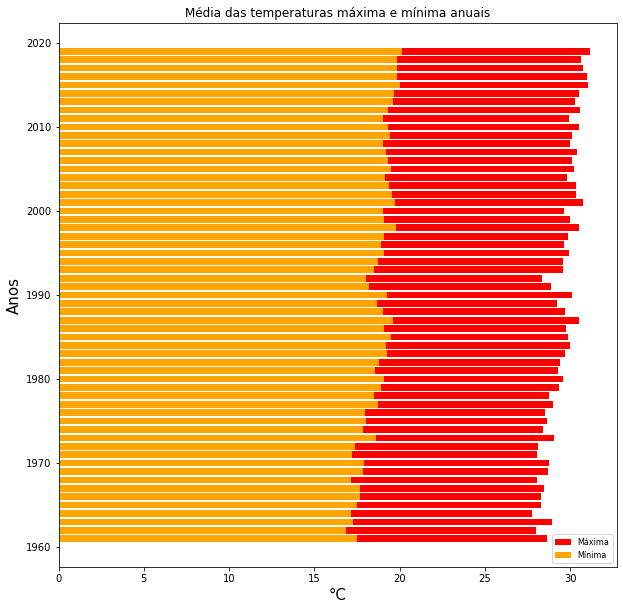

In [115]:
plt.figure(figsize=(10,10))

plt.barh(dfGrafico.index, dfGrafico.TempMaxima, height = 0.8, label='Máxima', color='red')
plt.barh(dfGrafico.index, dfGrafico.TempMinima, height = 0.8, label='Mínima', color='orange')
plt.title('Média das temperaturas máxima e mínima anuais')
plt.xlabel('°C', fontsize=15)
plt.ylabel('Anos', fontsize=15)
plt.legend(fontsize=8)

plt.savefig('TemperaturaBarras.png')
    
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


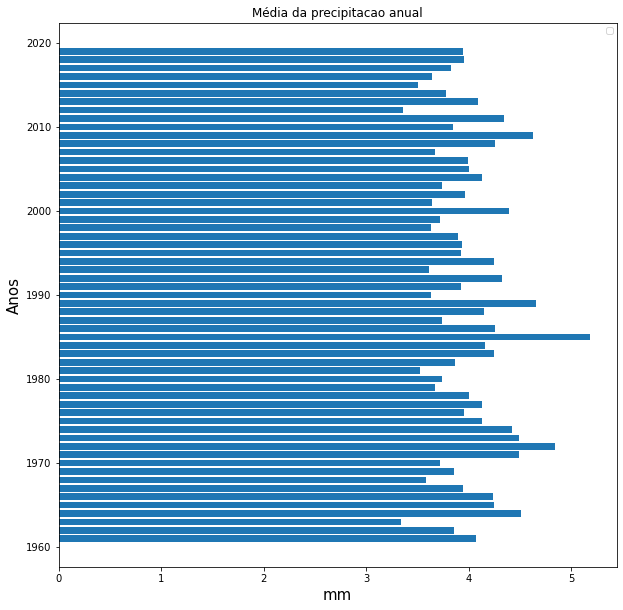

In [116]:
plt.figure(figsize=(10,10))

plt.barh(dfGrafico.index, dfGrafico.Precipitacao, height = 0.8)
plt.title('Média da precipitacao anual')
plt.xlabel('mm', fontsize=15)
plt.ylabel('Anos', fontsize=15)
plt.legend(loc='best', fontsize=8)

plt.savefig('PrecipitacaoBarras.png')
    
plt.show()

In [123]:
dfGrafico.TempMaxima.mean()

29.54911412828082

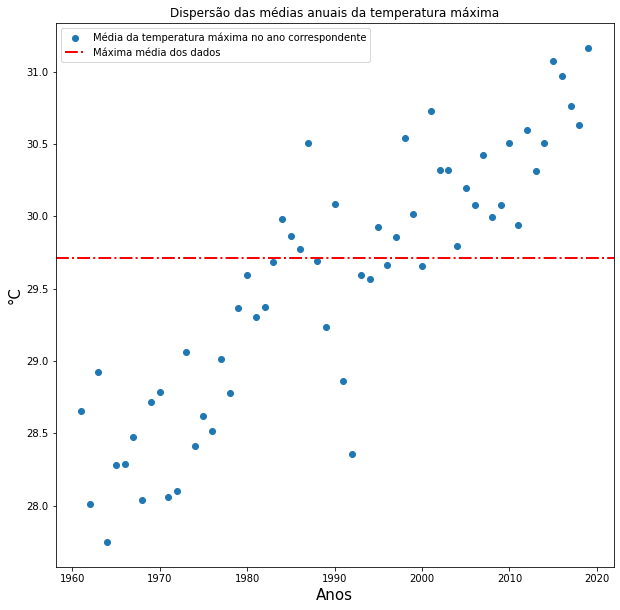

In [124]:
plt.figure(figsize=(10,10))

plt.scatter(dfGrafico.index, dfGrafico.TempMaxima, label='Média da temperatura máxima no ano correspondente')
plt.axhline(y=29.71, color='red', linestyle='-.', linewidth=2, label='Máxima média dos dados')
plt.title('Dispersão das médias anuais da temperatura máxima')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize=10)

plt.savefig('TemperaturaMaximaDispersao.png')
    
plt.show()

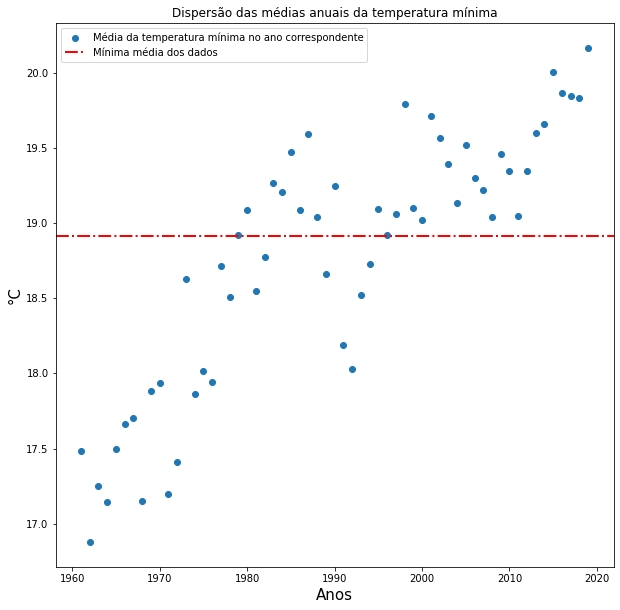

In [128]:
plt.figure(figsize=(10,10))

plt.scatter(dfGrafico.index, dfGrafico.TempMinima, label='Média da temperatura mínima no ano correspondente')
plt.axhline(y=18.91, color='red', linestyle='-.', linewidth=2, label='Mínima média dos dados')
plt.title('Dispersão das médias anuais da temperatura mínima')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize=10)

plt.savefig('TemperaturaMinimaDispersao.png')
    
plt.show()

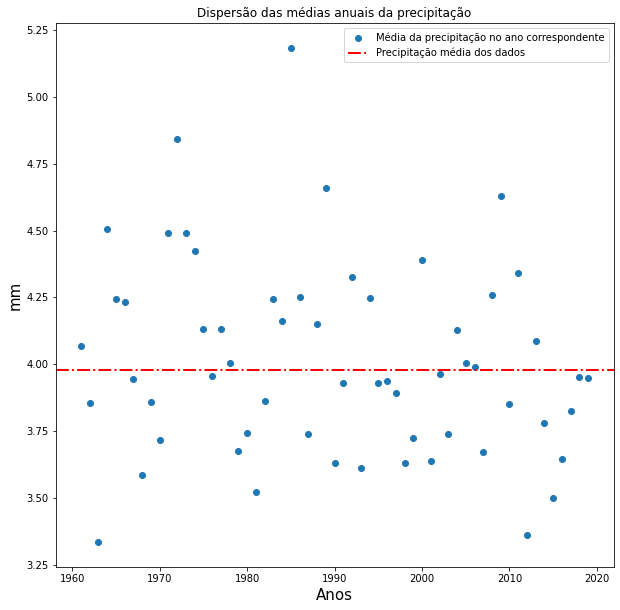

In [126]:
plt.figure(figsize=(10,10))

plt.scatter(dfGrafico.index, dfGrafico.Precipitacao, label='Média da precipitação no ano correspondente')
plt.axhline(y=3.98, color='red', linestyle='-.', linewidth=2, label='Precipitação média dos dados')
plt.title('Dispersão das médias anuais da precipitação')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('mm', fontsize=15)
plt.legend(fontsize=10)

plt.savefig('PrecipitacaoDispersao.png')
    
plt.show()

In [ ]:
###MEDIA MENSAL PARA CADA ESTADO###

In [3]:
def agrupaPorMes(estado):
    dfDadosPrincipais['Data'] = pd.to_datetime(dfDadosPrincipais['Data'], format='%d/%m/%Y')

    dfEstado = dfDadosPrincipais[dfDadosPrincipais.Nome.str.contains('- ' + estado)].drop(columns=['Codigo'])

    dfMaxima = pd.DataFrame()
    dfMinima = pd.DataFrame()
    dfPrecipitacao = pd.DataFrame()

    for ano in range(1961, 2020):
        dfAgrupado = dfEstado[dfEstado.Data.dt.to_period('Y') == str(ano)].groupby([dfEstado['Data'].dt.month]).mean()
        dfMaxima = pd.concat([dfMaxima, dfAgrupado.TempMaxima.to_frame().transpose()], ignore_index=True)
        dfMinima = pd.concat([dfMinima, dfAgrupado.TempMinima.to_frame().transpose()], ignore_index=True)
        dfPrecipitacao = pd.concat([dfPrecipitacao, dfAgrupado.Precipitacao.to_frame().transpose()], ignore_index=True)
    
    dfMaxima.set_index(pd.Index(range(1961,2020)), inplace=True)
    dfMinima.set_index(pd.Index(range(1961,2020)), inplace=True)
    dfPrecipitacao.set_index(pd.Index(range(1961,2020)), inplace=True)
    
    dfMaxima = dfMaxima[[1,2,3,4,5,6,7,8,9,10,11,12]]
    dfMinima = dfMinima[[1,2,3,4,5,6,7,8,9,10,11,12]]
    dfPrecipitacao = dfPrecipitacao[[1,2,3,4,5,6,7,8,9,10,11,12]]
    
    return dfMaxima, dfMinima, dfPrecipitacao

In [4]:
def trataDataFrames(dfMaxima, dfMinima, dfPrecipitacao):    
    dfMaxima.dropna(thresh=1, inplace = True)
    dfMinima.dropna(thresh=1, inplace = True)
    dfPrecipitacao.dropna(thresh=1, inplace = True)
    
    for mes in range(1,13):
        dfMaxima.update(dfMaxima[mes].fillna(dfMaxima[mes].mean()))
        dfMinima.update(dfMinima[mes].fillna(dfMinima[mes].mean()))
        dfPrecipitacao.update(dfPrecipitacao[mes].fillna(dfPrecipitacao[mes].mean()))

In [352]:
dfMaxima, dfMinima, dfPrecipitacao = agrupaPorMes("RS")

In [353]:
trataDataFrames(dfMaxima, dfMinima, dfPrecipitacao)

In [359]:
dfMinima.describe().loc['mean'].mean()

13.884308527154538

In [403]:
def editaGrafico(ax, titulo, dataFrame):
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    maxValues = dataFrame.describe().loc["max"].tolist()
    maxValues += maxValues[:1]
    minValues = dataFrame.describe().loc["min"].tolist()
    minValues += minValues[:1]
    meanValues = dataFrame.describe().loc["mean"].tolist()
    meanValues += meanValues[:1]
    
    ax.plot(angles, maxValues, color='red', linewidth=2, label='Máxima')
    ax.plot(angles, minValues, color='blue', linewidth=2, label='Mínima')
    ax.plot(angles, meanValues, color='orange', linewidth=2, label='Média')
    
    ax.set_ylim(dataFrame.describe().loc["min"].min(), dataFrame.describe().loc["max"].max())
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles), ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez", "Jan"])

    ax.set_title(titulo, y=1.08)

    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), prop={'size': 10})

/tmp/ipykernel_6304/613964765.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 20), subplot_kw=dict(polar=True))


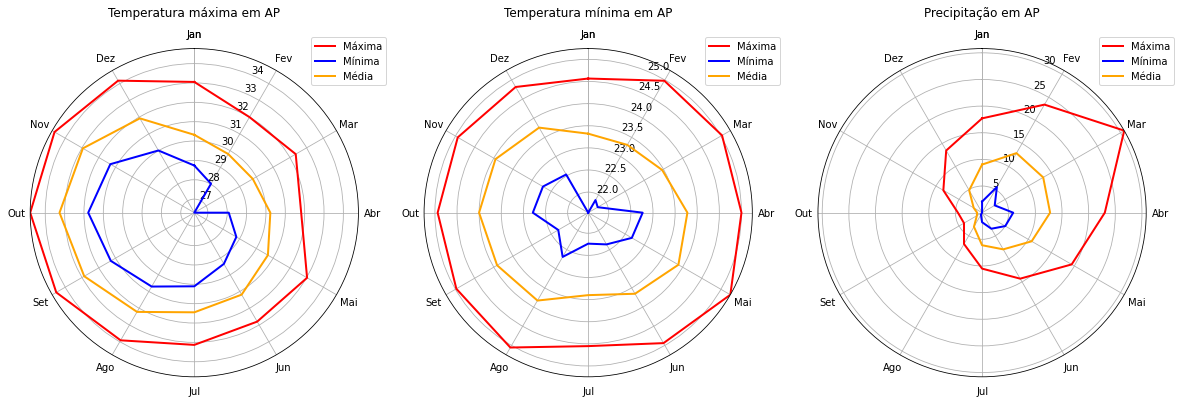

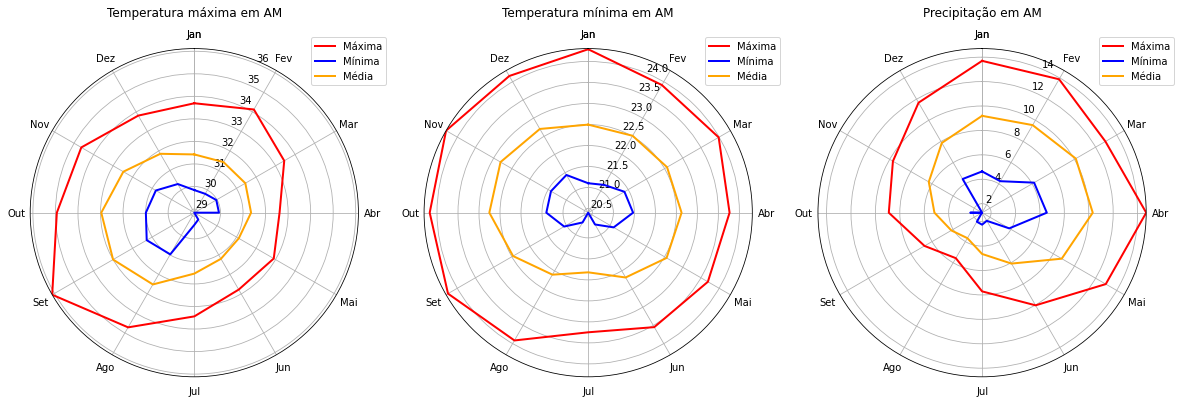

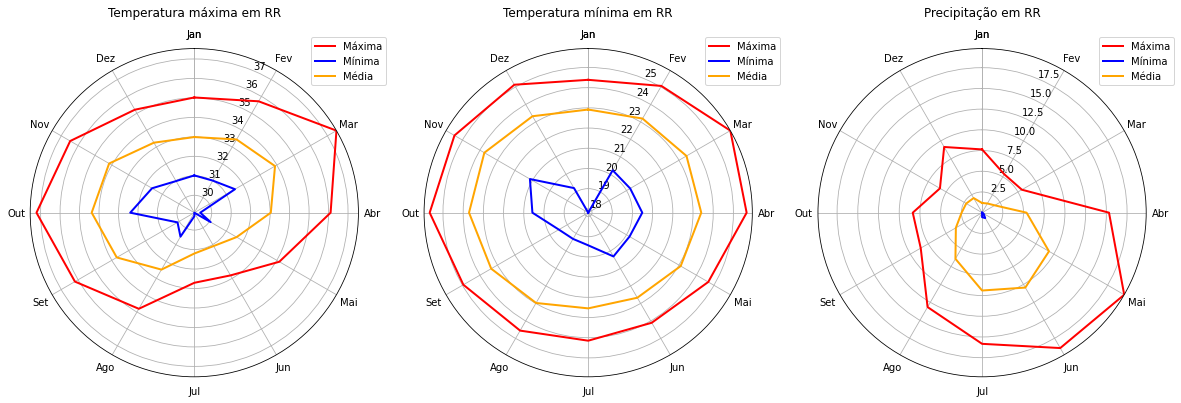

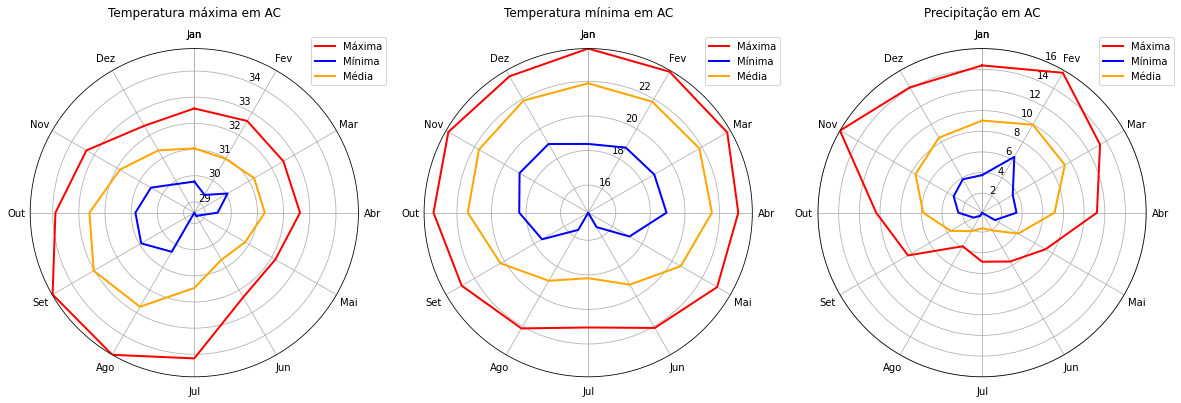

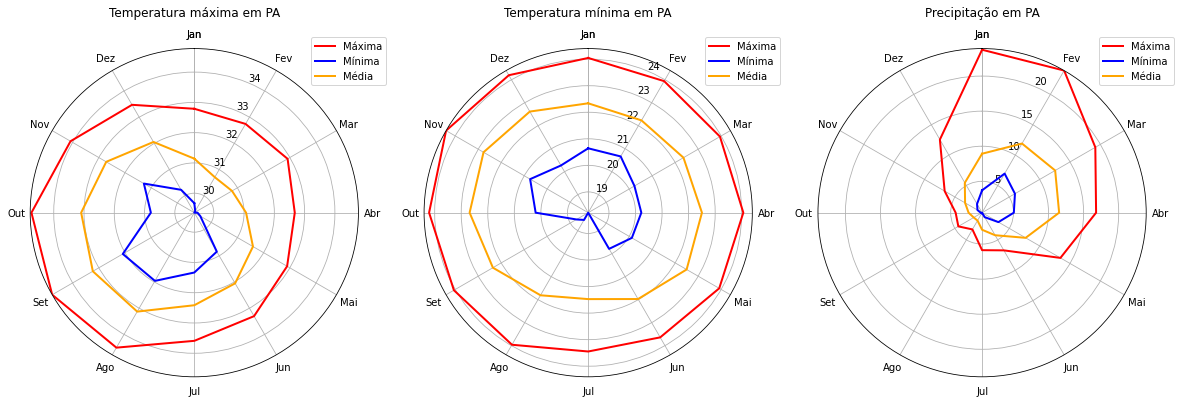

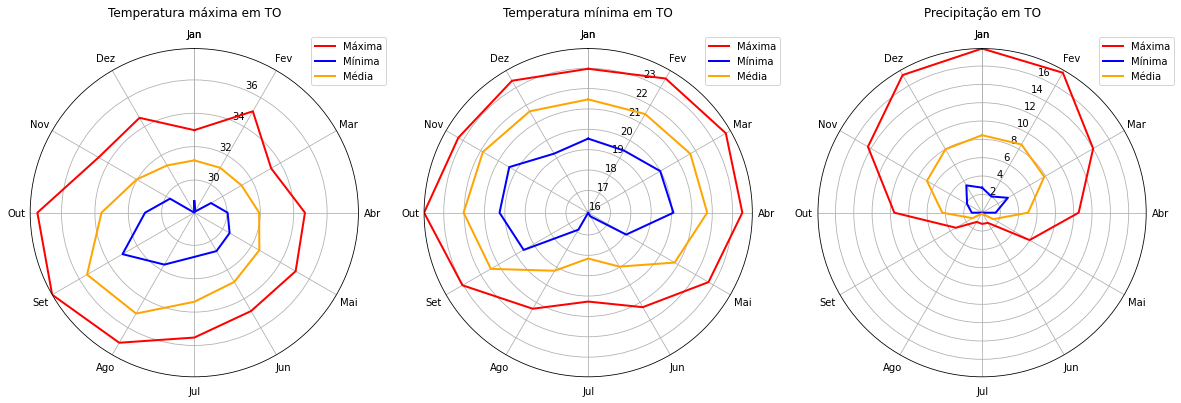

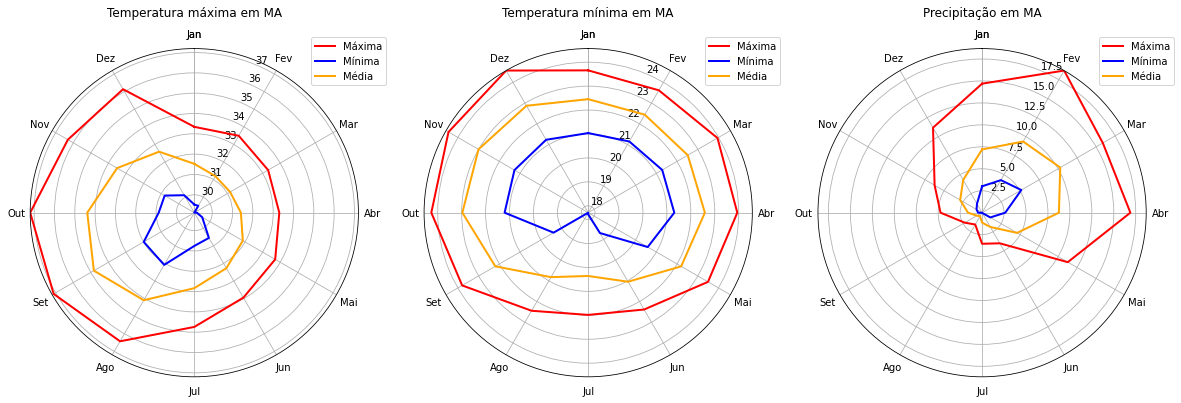

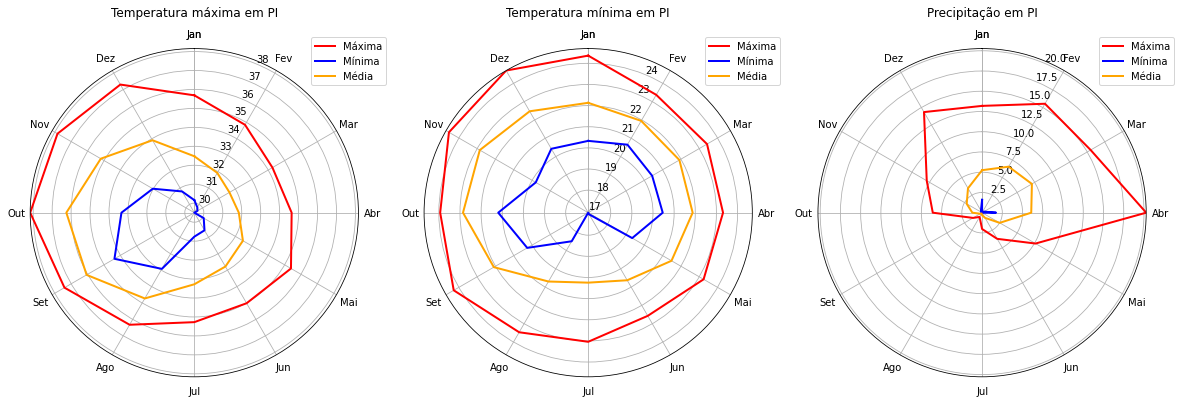

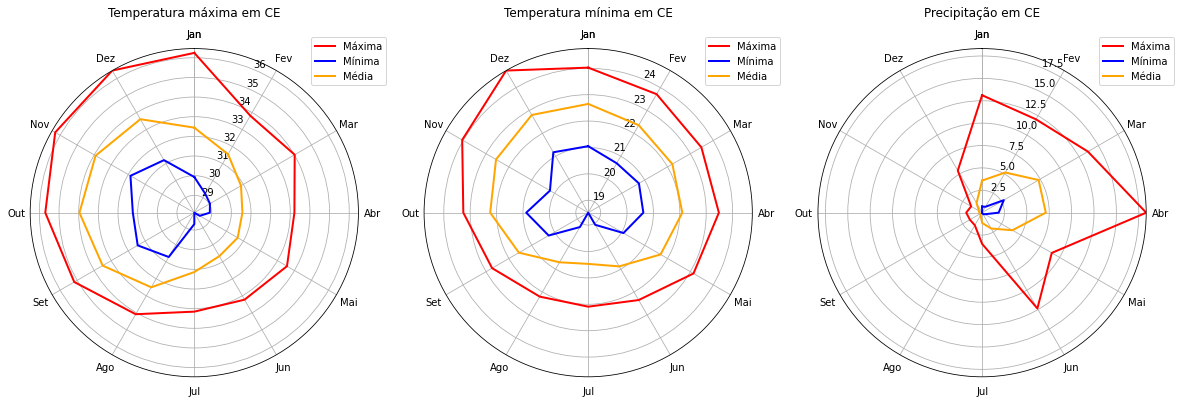

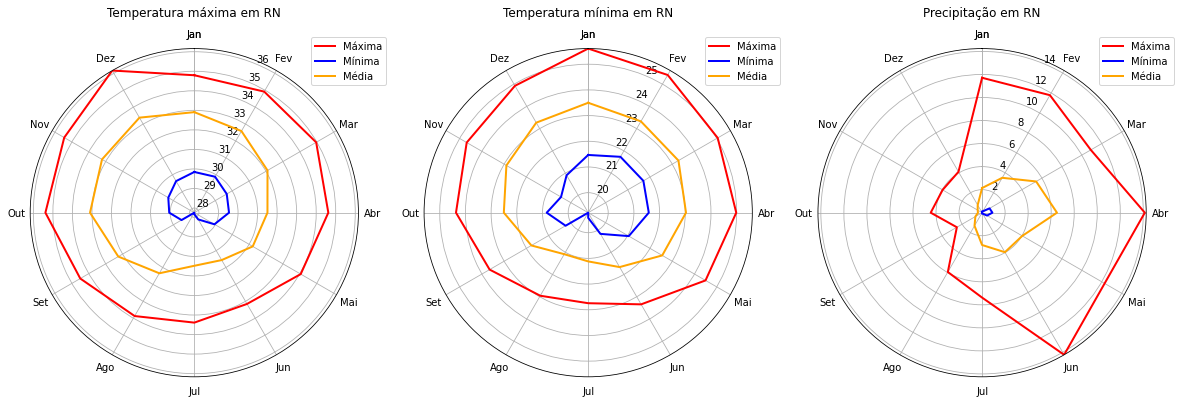

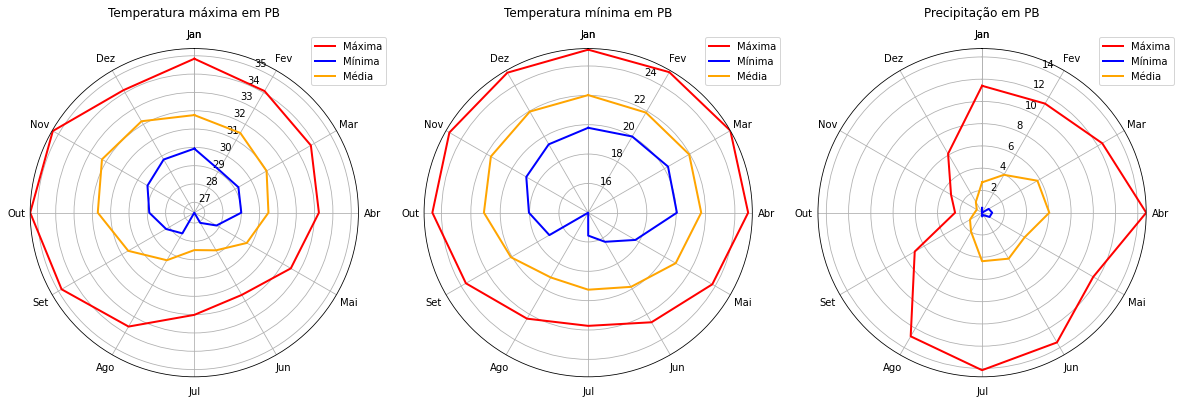

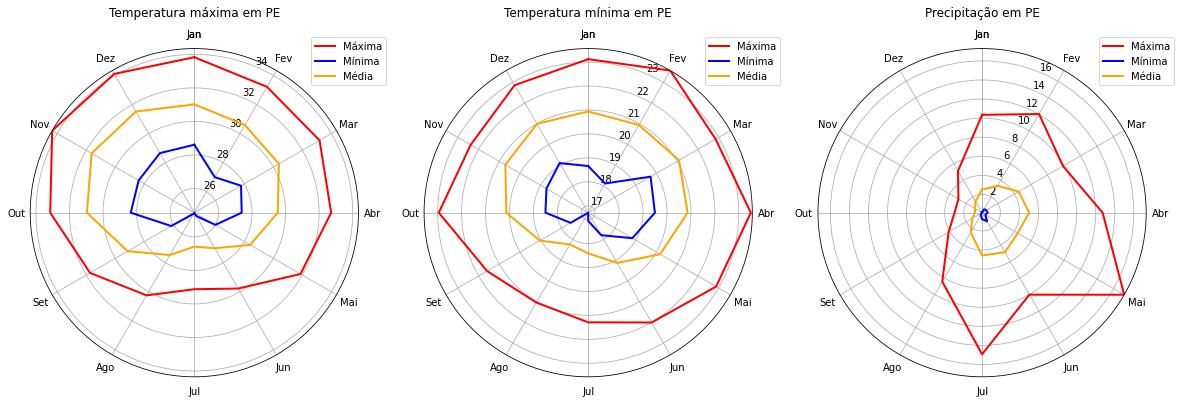

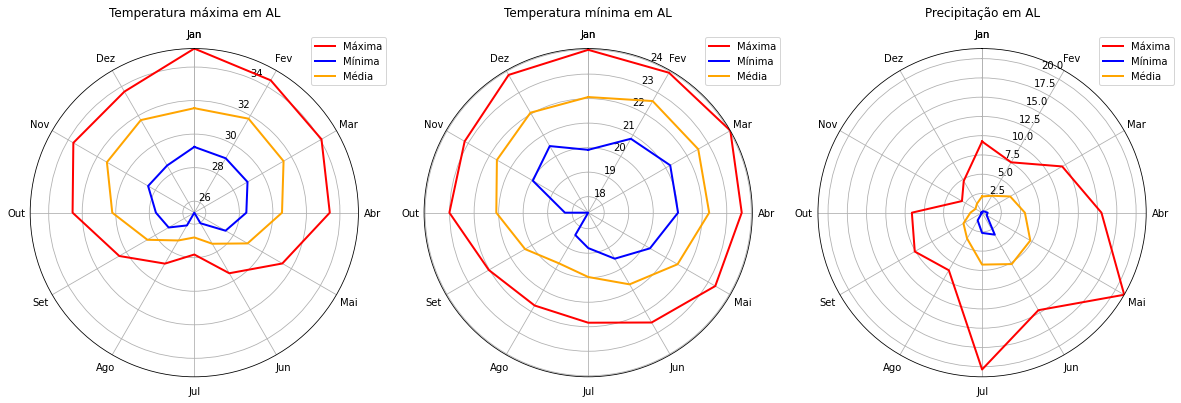

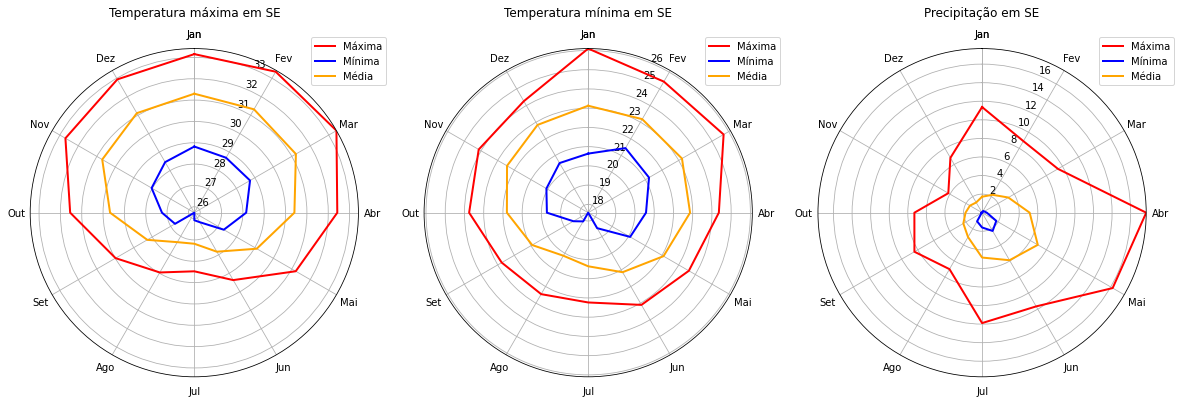

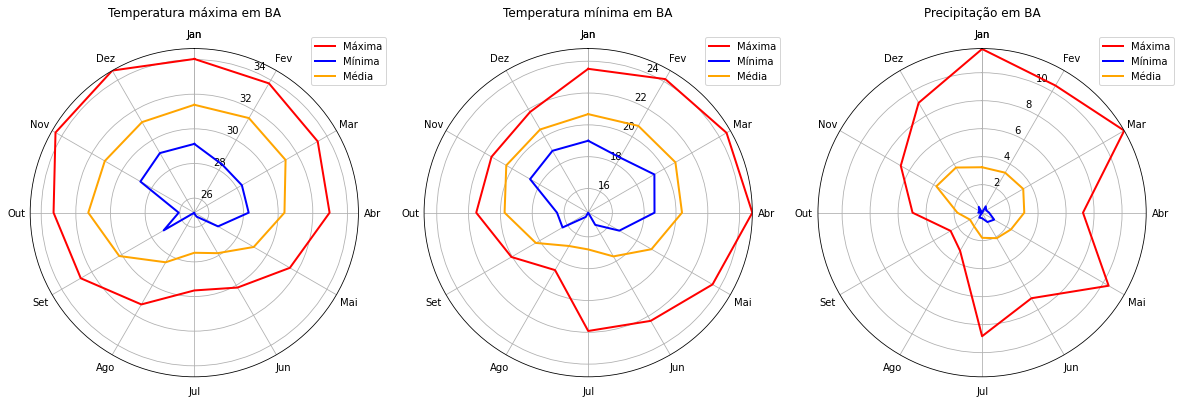

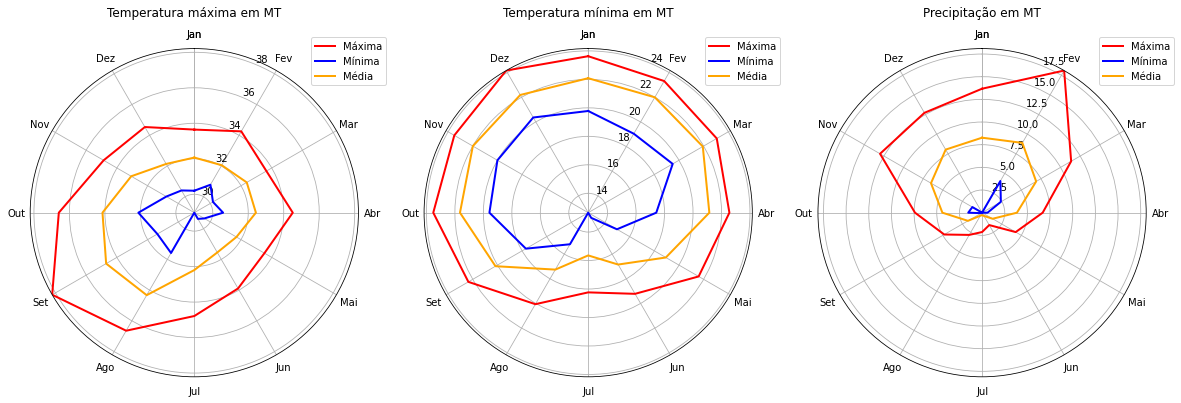

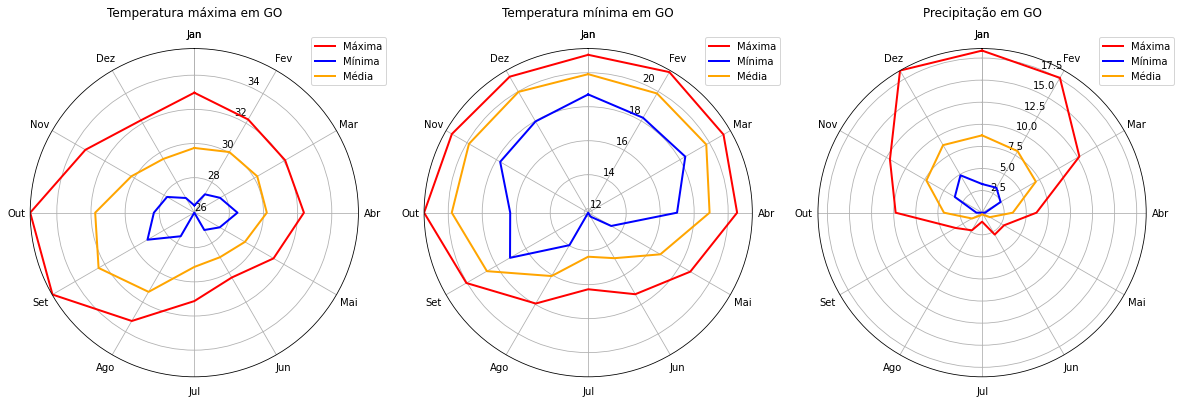

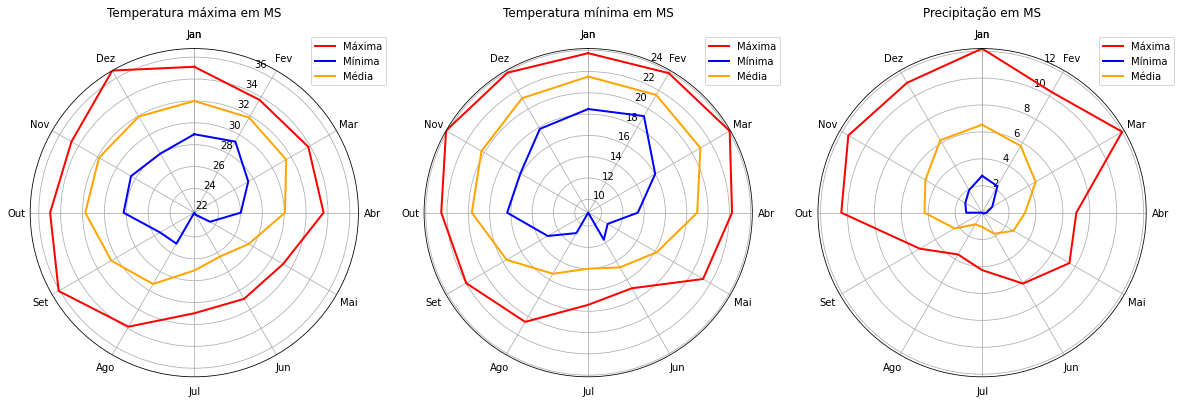

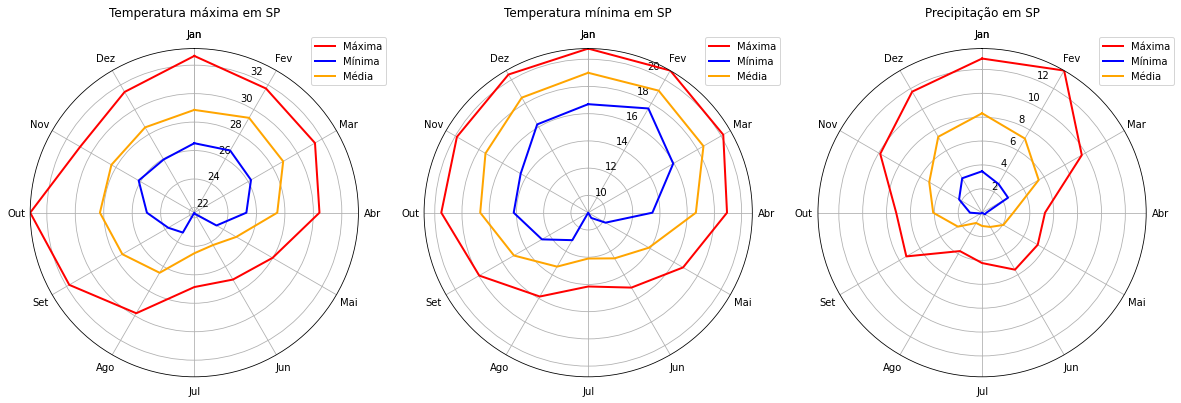

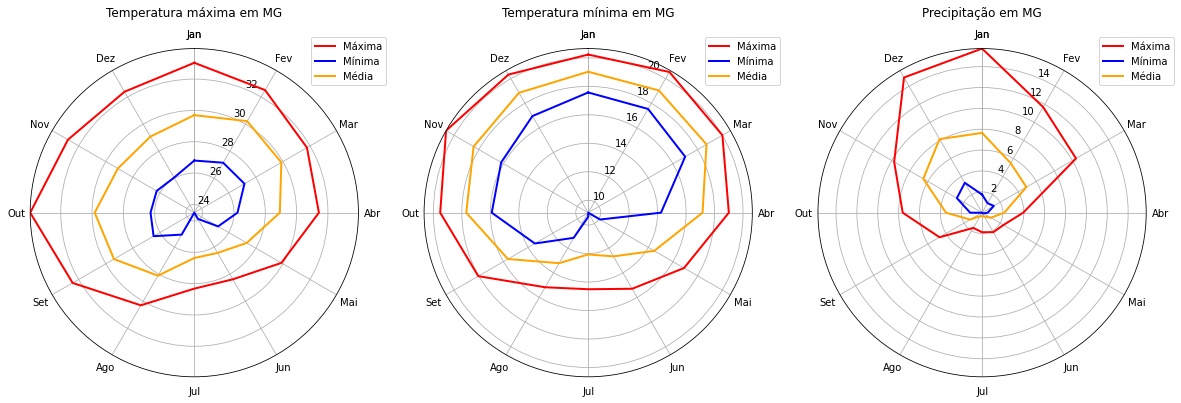

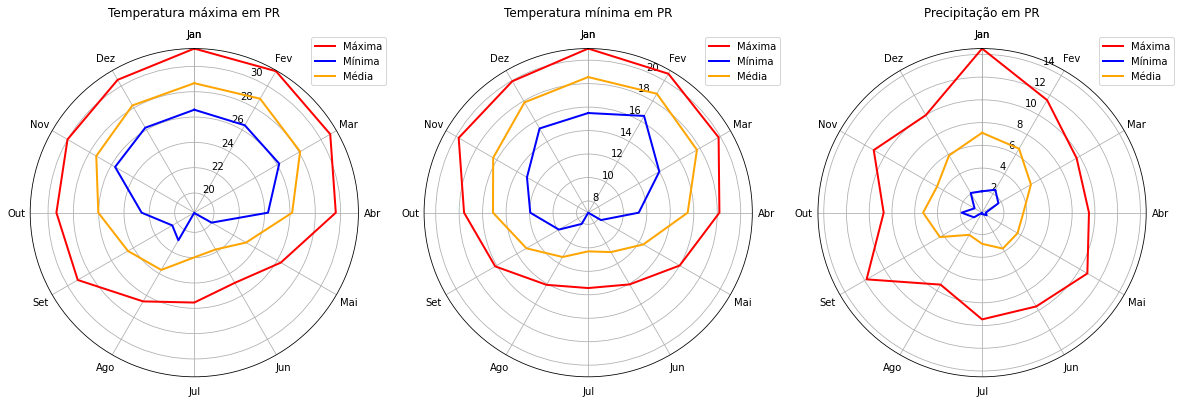

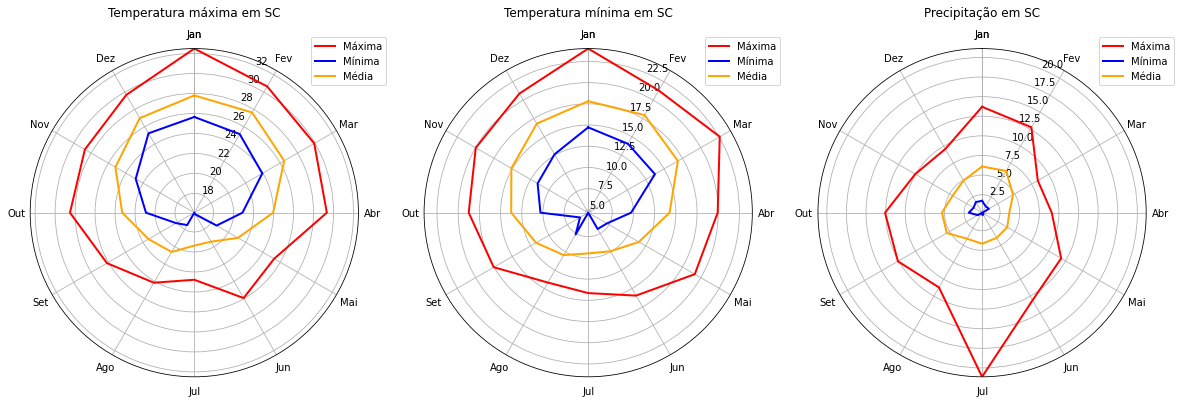

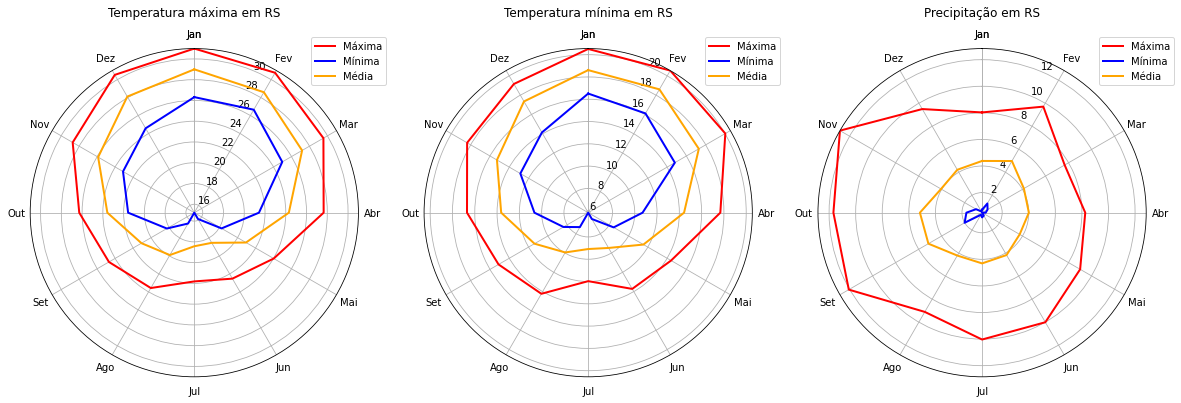

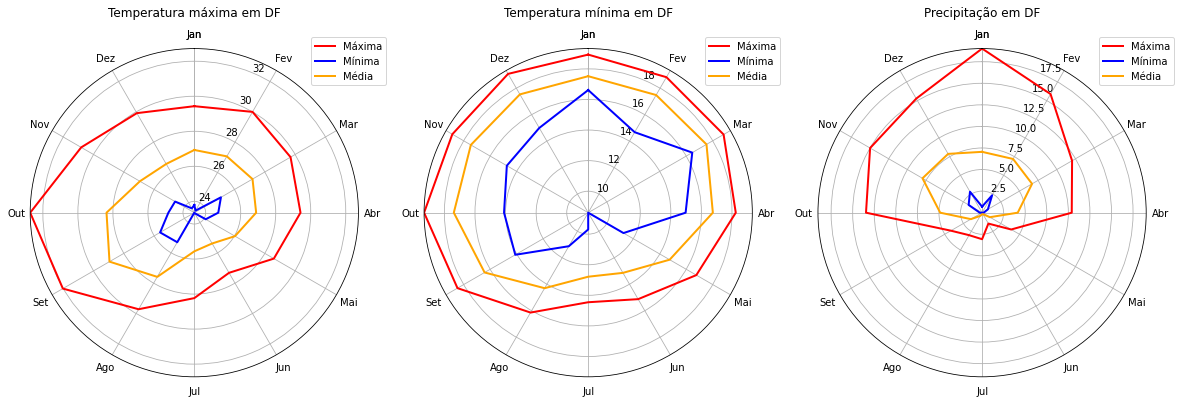

In [407]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'PR', 'SC', 'RS', 'DF']
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
num_vars = len(labels)

# estados = ['RJ', 'ES']
    
for estado in estados:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 20), subplot_kw=dict(polar=True))
    dfMaxima, dfMinima, dfPrecipitacao = agrupaPorMes(estado)
    trataDataFrames(dfMaxima, dfMinima, dfPrecipitacao)
    editaGrafico(ax1, 'Temperatura máxima em ' + estado, dfMaxima)
    editaGrafico(ax2, 'Temperatura mínima em ' + estado, dfMinima)
    editaGrafico(ax3, 'Precipitação em ' + estado, dfPrecipitacao)
    fig.savefig('Aranha' + estado + '.png', bbox_inches ="tight", format='png')

In [ ]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']

fig = plt.figure(i)
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.title('Temperatura no mes de ' + mes)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura (Celsius)', fontsize=15)
plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
plt.legend()
fig.savefig(figura, format='pdf')
fig.clear(True)

In [ ]:
# planilhaEstado = planilha[planilha.Nome.str.contains('- AM')]
# planilhaEstado['Data'] = pd.to_datetime(planilhaEstado['Data'])
planilhaEstado['Data'] = pd.to_datetime(planilhaEstado['Data'], format='%d/%m/%Y')

In [ ]:
######TESTES######

In [ ]:
dfmaxima = pd.DataFrame({'Ano': [],
                         1: [], 
                         2: [], 
                         3: [], 
                         4: [], 
                         5: [], 
                         6: [], 
                         7: [], 
                         8: [], 
                         9: [], 
                         10: [], 
                         11: [], 
                         12: []})

dfminima = pd.DataFrame({'Ano': [],
                         1: [], 
                         2: [], 
                         3: [], 
                         4: [], 
                         5: [], 
                         6: [], 
                         7: [], 
                         8: [], 
                         9: [], 
                         10: [], 
                         11: [], 
                         12: []})

dfprecipitacao = pd.DataFrame({'Ano': [],
                               1: [], 
                               2: [], 
                               3: [], 
                               4: [], 
                               5: [], 
                               6: [], 
                               7: [], 
                               8: [], 
                               9: [], 
                               10: [], 
                               11: [], 
                               12: []})


for ano in range(1961, 2020, 1):
    dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(ano)]
    dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
    dftranspose = dfano.transpose()
    dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
    dfmaxima.Ano.mask(dfmaxima.index == ano - 1961, str(ano), inplace=True)
    dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
    dfminima.Ano.mask(dfminima.index == ano - 1961, str(ano), inplace=True)
    dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
    dfprecipitacao.Ano.mask(dfprecipitacao.index == ano - 1961, str(ano), inplace=True)

In [ ]:
y = teste.iloc[:,2].values.reshape(-1, 1)  #dependent variable vector
X = teste.iloc[:,6].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score

In [ ]:
# dfmanaus = planilhaEstado[planilhaEstado.Codigo == 82331]
dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(1961)]
dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
dftranspose = dfano.transpose()
dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
dfmaxima.Ano.mask(dfmaxima.index == 1974 - 1961, str(1974), inplace=True)

dftranspose
# dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
# dfminima.Ano.mask(dfminima.index == 1974 - 1961, str(1974), inplace=True)
# dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
# dfprecipitacao.Ano.mask(dfprecipitacao.index == 1974 - 1961, str(1974), inplace=True)

In [ ]:
dfmaxima.dropna(thresh=2, inplace = True)
# media = dfmaxima[10].mean()
dfmaxima.update(dfmaxima[10].fillna(dfmaxima[10].mean()))
dfmaxima

In [ ]:
######PLANILHA DE SERIE TEMPORAL######

In [8]:
planilhaEstado = planilha
planilhaEstado['Data'] = pd.to_datetime(planilha['Data'], format='%d/%m/%Y')
dfSerie = planilhaEstado.drop(columns=['Codigo']).groupby([planilhaEstado['Data']]).mean()
dfSerie['Data'] = dfSerie.index
dfSerie = dfSerie.set_index(pd.Index(range(0, len(dfSerie), 1)))

In [13]:
##########PLANILHA DE TEMPERATURAS COM MEDIAS MENSAIS POR ANO###############
dfMes = pd.DataFrame()
dfMes['Data'] = 'bla'
for ano in range(1961,2020):
    mes = 1
    while(mes<13):
        if(mes<10):
            dfMes = dfMes.append(dfSerie.groupby(dfSerie.Data.astype(str).str.contains(str(ano) + '-0' + str(mes))).mean())
            dfMes.iloc[len(dfMes)-1,0] = str(ano) + "-0" +str(mes)
        else:
            dfMes = dfMes.append(dfSerie.groupby(dfSerie.Data.astype(str).str.contains(str(ano) + '-' + str(mes))).mean())
            dfMes.iloc[len(dfMes)-1,0] = str(ano) + "-" +str(mes)
        dfMes = dfMes.loc[dfMes.index == True]
    
        mes = mes + 1

AttributeError: 'DataFrame' object has no attribute 'concat'

In [10]:
dfMes['Data'] = pd.to_datetime(dfMes['Data'],format='%Y-%m')
dfMes

Data  Precipitacao  TempMaxima  TempMinima  Temp Comp Media
True 1961-01-01      7.738661   29.602564   19.819339        24.071514
True 1961-02-01      7.003770   29.670813   19.466936        23.856997
True 1961-03-01      5.465665   29.345229   18.968316        23.468247
True 1961-04-01      4.567821   28.390352   17.866894        22.422232
True 1961-05-01      2.913339   27.061363   16.072407        20.828054
...         ...           ...         ...         ...              ...
True 2019-08-01      1.368147   29.994486   17.669398        23.209528
True 2019-09-01      1.525040   32.127010   19.558852        25.217280
True 2019-10-01      2.874899   32.502979   20.664635        25.902348
True 2019-11-01      3.740362   32.458848   21.446351        26.231302
True 2019-12-01      4.222470   32.451777   21.697043        26.389818

[708 rows x 5 columns]

In [11]:
dfSerie = dfSerie.loc[dfSerie.index < 3287]
dfSerie

Precipitacao  TempMaxima  TempMinima  Temp Comp Media       Data
0         0.003636   29.479091   19.959091        24.139818 1961-01-01
1         7.985714   29.659821   20.108036        24.295714 1961-01-02
2         8.669027   30.201770   20.102655        24.283186 1961-01-03
3        11.321930   29.266667   19.904386        23.926140 1961-01-04
4         8.324779   29.444248   20.043363        24.133805 1961-01-05
...            ...         ...         ...              ...        ...
3282      7.030534   28.636641   18.383206        23.139542 1969-12-27
3283      3.339695   29.177099   19.227481        23.747328 1969-12-28
3284      2.595420   29.401527   19.808397        23.876336 1969-12-29
3285      4.878030   29.293182   19.867424        24.080909 1969-12-30
3286      4.486466   29.231579   20.206015        24.049624 1969-12-31

[3287 rows x 5 columns]

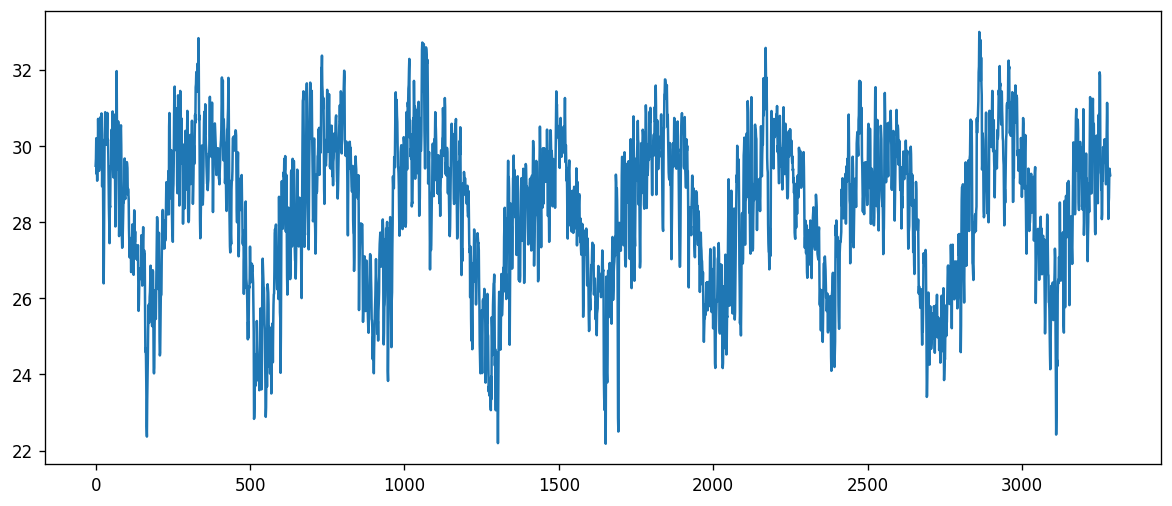

In [12]:
dadosPlot = dfSerie[dfSerie.Data.astype(str).str.contains('-11-')]
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})
plt.plot(dfSerie.index, dfSerie.TempMaxima)

In [ ]:
######ANALISES DA SERIE######

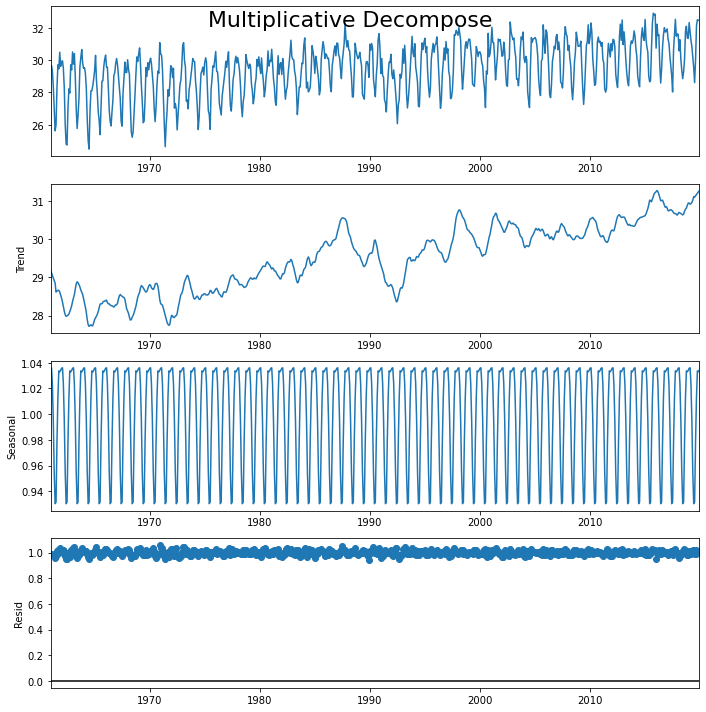

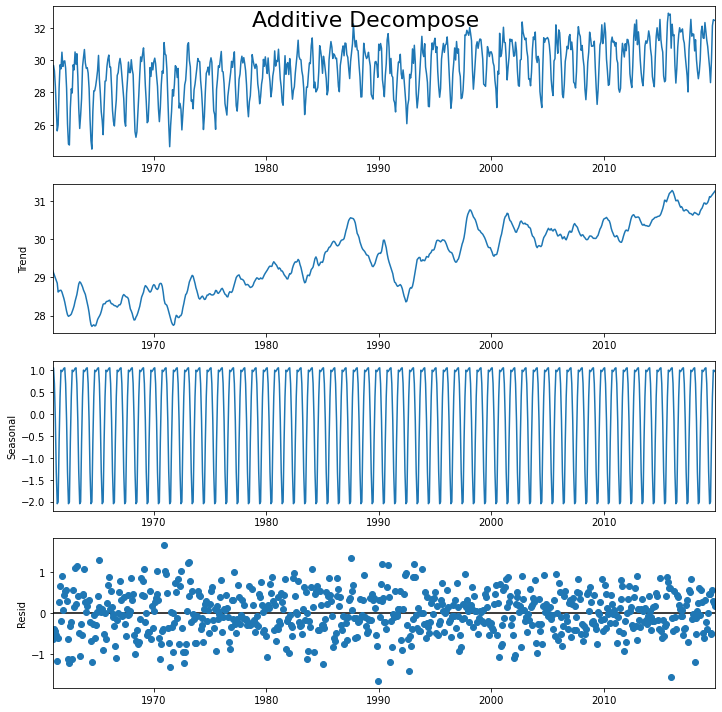

In [7]:
######COMPONENTES ADITIVAS E MULTIPLICATIVAS######
df = pd.DataFrame()
df['Data'] = dfMes.Data
df['Maxima'] = dfMes.TempMaxima
df = df.set_index('Data')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [8]:
# TESTE PARA SERIE ESTACIONARIA
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0908331168786876
p-value: 0.24821659183799905
Critial Values:
   1%, -3.4398214107097225
Critial Values:
   5%, -2.8657196436385663
Critial Values:
   10%, -2.5689957624690525


/home/fnadona/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


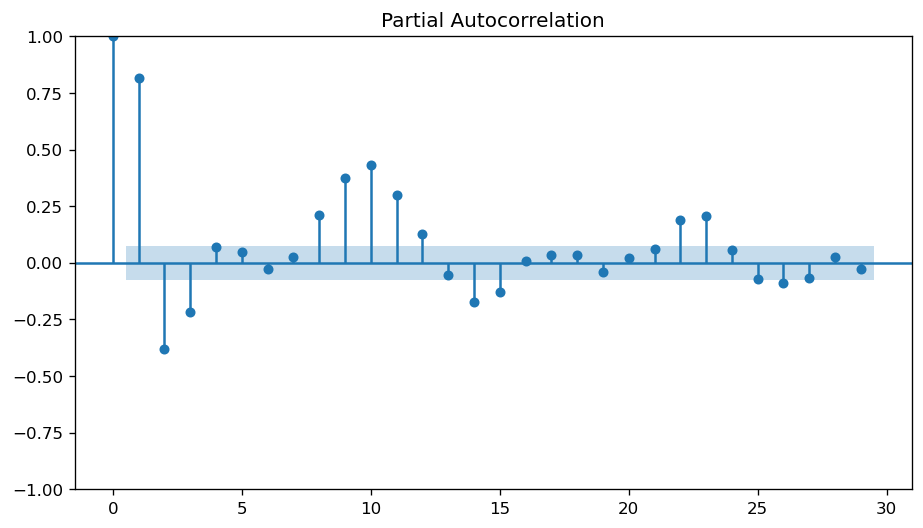

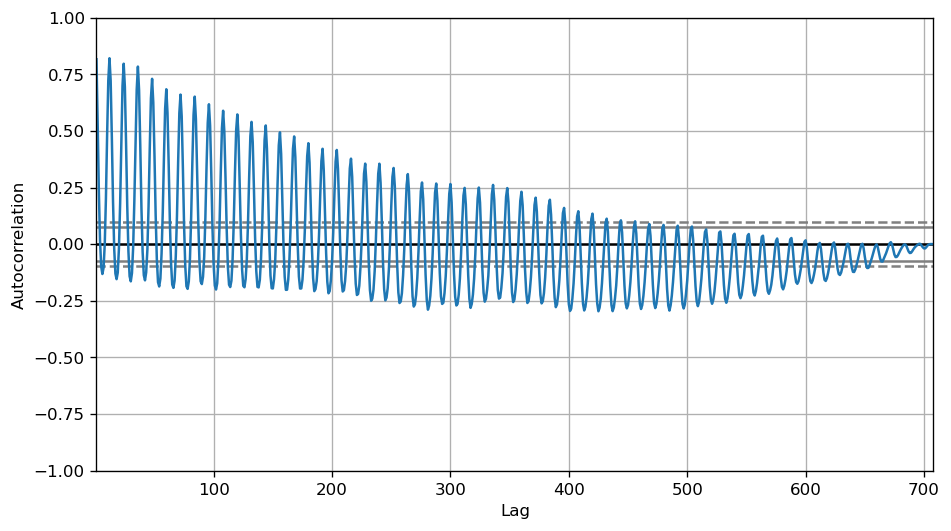

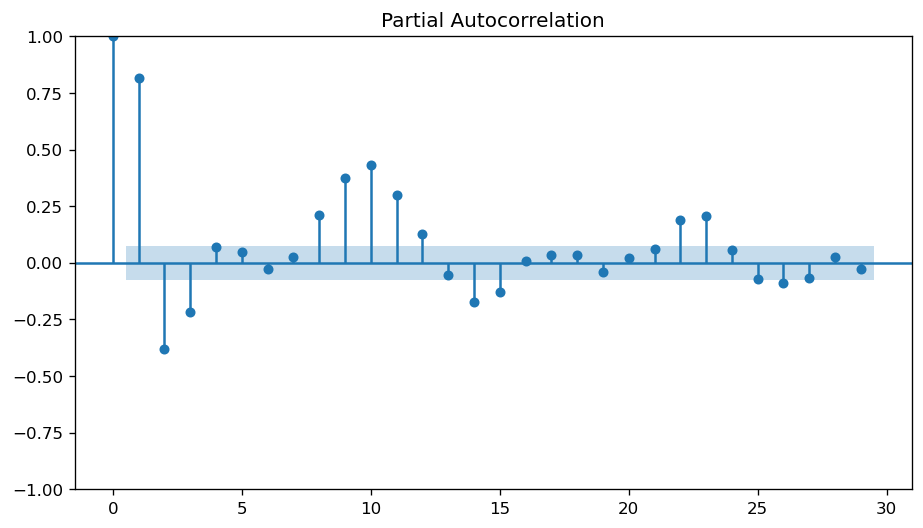

In [8]:
#PLOT DE AUTOCORRELACAO

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df)
plot_pacf(df)

[ 1.00000000e+00  8.16278992e-01  5.40360137e-01  2.38237135e-01
  1.79674382e-02 -9.80408871e-02 -1.31704818e-01 -1.04372783e-01
 -8.40238370e-04  2.02800786e-01  4.80968609e-01  7.23198766e-01
  8.20911064e-01  7.21297613e-01  4.70179639e-01  1.86730412e-01
 -2.13790698e-02 -1.29636386e-01 -1.54479032e-01 -1.25286608e-01
 -1.75278451e-02  1.78944996e-01  4.50858464e-01  6.99000991e-01
  7.96725722e-01  6.93772340e-01  4.47370315e-01  1.69655717e-01
 -3.18332965e-02 -1.41823806e-01 -1.64122246e-01 -1.27454868e-01
 -1.34520038e-02  1.90438133e-01  4.47384548e-01  6.82366678e-01
  7.84044803e-01  6.79693590e-01  4.37954495e-01  1.58904946e-01
 -3.38947398e-02 -1.37265376e-01 -1.59667258e-01 -1.24397446e-01
 -2.58143949e-02  1.65712395e-01  4.20122397e-01  6.43280733e-01
  7.30069144e-01  6.25171540e-01  3.94381417e-01]


/home/fnadona/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


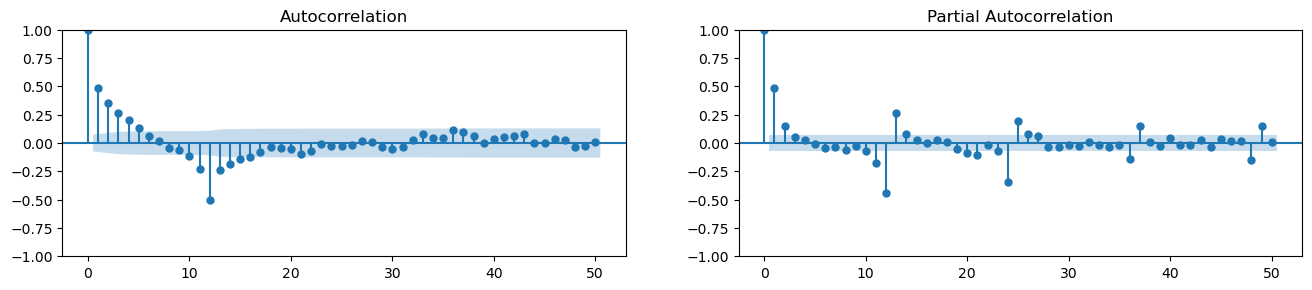

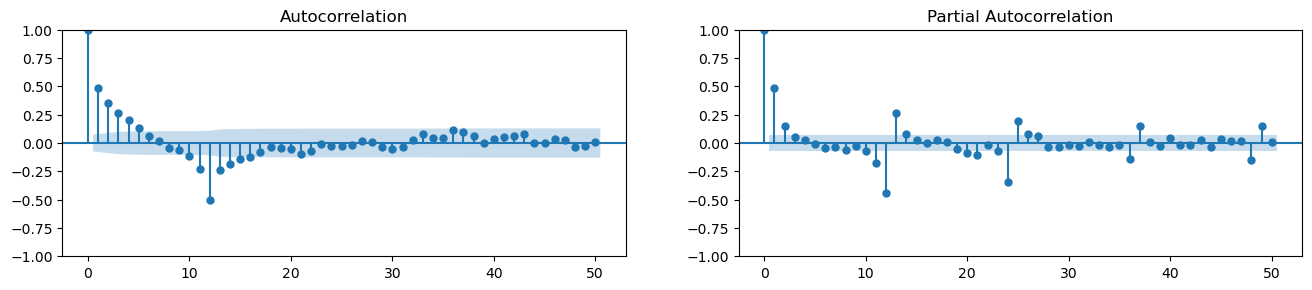

In [9]:
acf_50 = acf(df, nlags=50)
print(acf_50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.diff(12).dropna(), lags=50, ax=axes[0])
plot_pacf(df.diff(12).dropna(), lags=50, ax=axes[1])

/home/fnadona/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/fnadona/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/fnadona/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


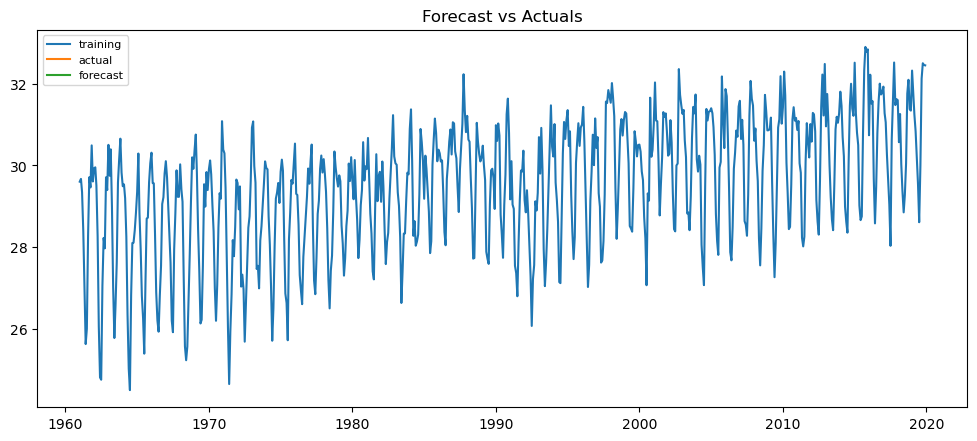

In [11]:
train = df.Maxima[:2800]
test = df.Maxima[2800:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(2, 0, 0))  
fitted = model.fit()  

# Forecast
fc= fitted.forecast(467, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# model = ARIMA(df, order=(1,1,1))
# model_fit = model.fit()
# print(model_fit.summary())

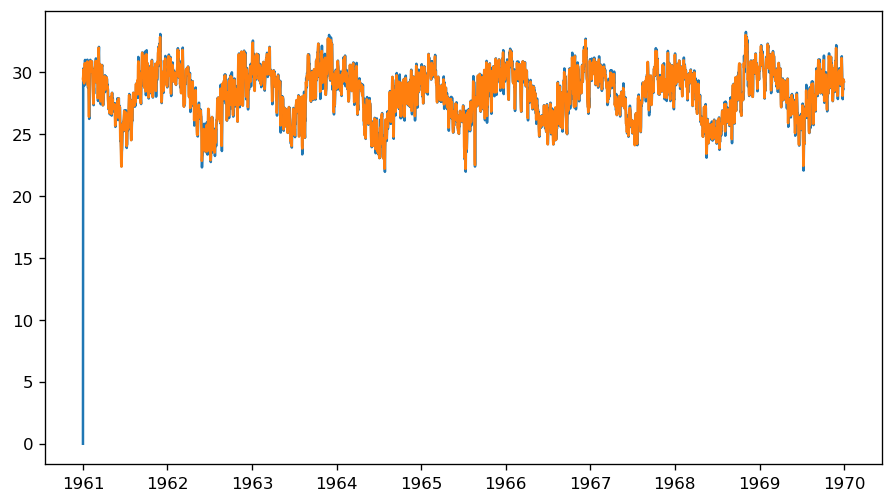

In [70]:
plt.plot(model_fit.predict(dynamic=False))
plt.plot(df)
plt.show()

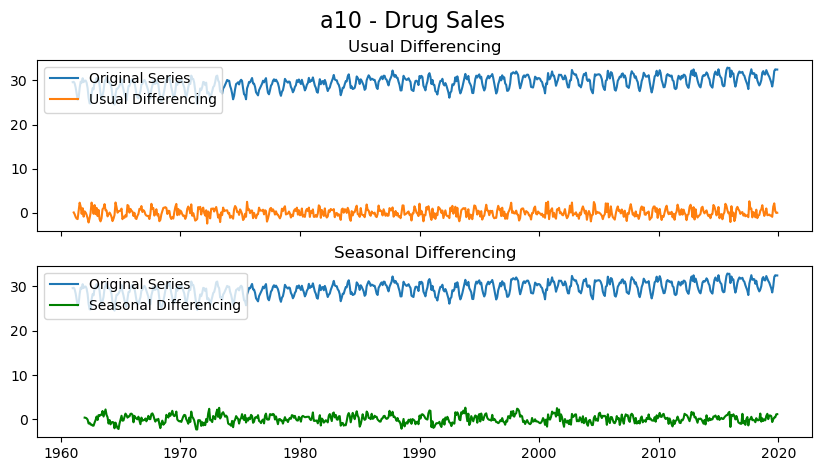

In [10]:
#APLICANDO SARIMA

fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [11]:
# Seasonal - fit stepwise auto-ARIMA

train = df.Maxima[:600]
test = df.Maxima[600:]

smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1541.439, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1181.119, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1100.274, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1540.551, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1421.024, Time=0.14 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1102.272, Time=1.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1102.272, Time=1.78 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1244.184, Time=0.45 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1104.218, Time=3.42 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1249.203, Time=0.60 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(0,0,1)(0,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  600
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -546.137
Date:                            Sun, 30 Jan 2022   AIC                           1100.274
Time:                                    18:19:57   BIC                           1117.781
Sample:                                         0   HQIC                          1107.095
                                            - 600                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0461      0.005      9.105      0.000       0.036       0.056
ma.L1          0.4248      0.036     11.671      0.000       0.353       0.496
ma.S.L12      -0.8813      0.023    -38.907      0.000      -0.926      -0.837
sigma2         0.3638      0.021     16.925      0.000       0.322       0.406
===================================================================================
Ljung-Box (L1) (Q):                  11.01   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               0.96   Skew:                            -0.04
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

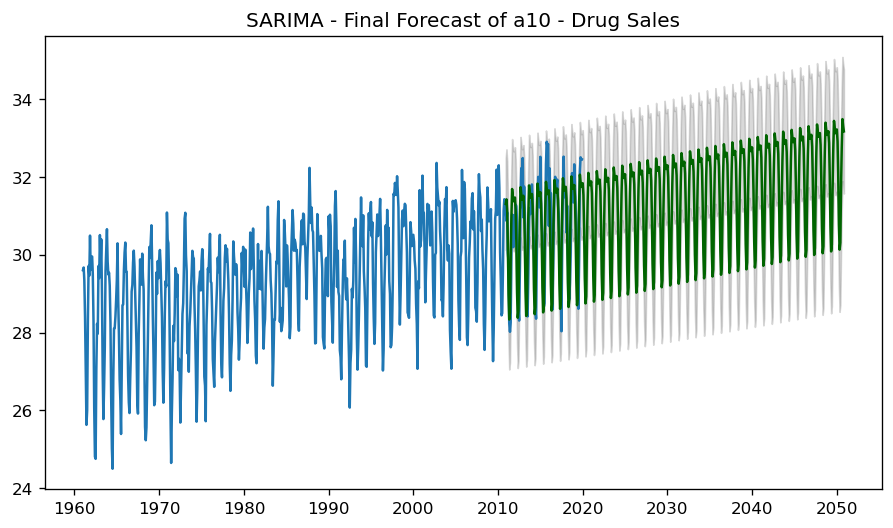

In [17]:
# Forecast
n_periods = 480
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

# smodel.plot_diagnostics(figsize=(7,5))
# plt.show()

/home/fnadona/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


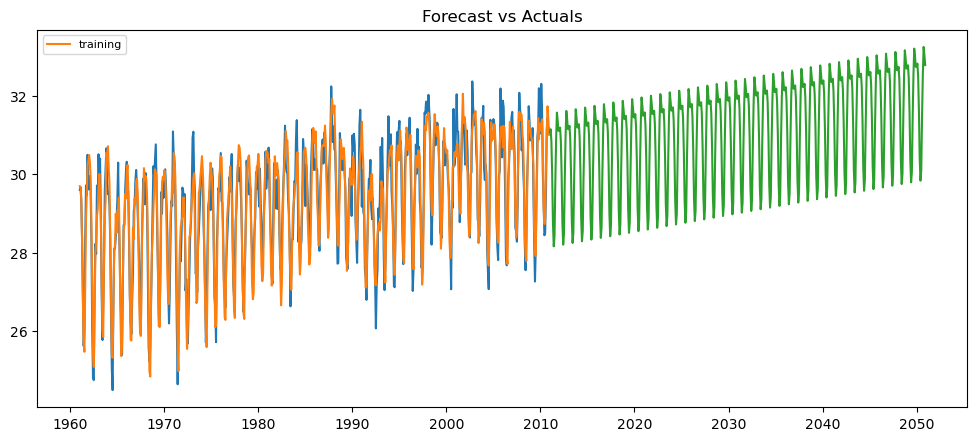

In [20]:
####APLICANDO EXPONENTIAL SMOOTHING

train = df.Maxima[:600]
test = df.Maxima[600:]

m = 12
alpha = 1/(2*m)

###SIMPLE
# modelo = SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False,use_brute=True)

###DOUBLE
# modelo = ExponentialSmoothing(train, trend='add').fit()
# predicao = modelo.forecast(108)

###TRIPLE
modelo = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
predicao = modelo.forecast(480)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train)
plt.plot(modelo.fittedvalues, label='training')
plt.plot(predicao)
# plt.plot(test)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
print(mean_absolute_error(train, modelo.fittedvalues))
print(mean_squared_error(train, modelo.fittedvalues))

0.477982934679274
0.35581193068176153


In [126]:
###########LSTM USANDO PYTORCH###########

tamanhoTreino = 600

treino = df.Maxima[:tamanhoTreino]
teste = df.Maxima[tamanhoTreino:]

In [127]:
scaler = MinMaxScaler(feature_range=(-1, 1))
treinoNormalizado = scaler.fit_transform(treino.iloc[:].values.reshape(-1, 1))

In [58]:
treinoNormalizado = torch.FloatTensor(treinoNormalizado).view(-1)

In [68]:
def criar_sequencia(dado, periodo):
    sequencia = []
    comprimento = len(dado)
    
    for i in range(comprimento-periodo):
        sequenciaTreino = dado[i:i+periodo]
        indiceTreino = dado[i+periodo:i+periodo+1]
        sequencia.append((sequenciaTreino ,indiceTreino))
    
    return sequencia

In [69]:
periodo = 12
sequenciaTreino = criar_sequencia(treinoNormalizado, periodo)

In [73]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [74]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
epochs = 150

for i in range(epochs):
    for seq, labels in sequenciaTreino:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00987798
epoch:  26 loss: 0.00004620
epoch:  51 loss: 0.00481923
epoch:  76 loss: 0.00789543
epoch: 101 loss: 0.00105903
epoch: 126 loss: 0.01096652
epoch: 149 loss: 0.0001560203


In [116]:
fut_pred = 107

test_inputs = treinoNormalizado[-periodo:].tolist()

In [117]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-periodo:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [118]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[periodo:] ).reshape(-1, 1))
# x = np.arange(2, 708, 1)
actual_predictions

array([[30.78535914],
       [29.96115492],
       [29.41857777],
       [29.08919307],
       [28.4565502 ],
       [28.65782351],
       [28.89964354],
       [29.22180913],
       [29.80747781],
       [30.38005372],
       [30.76443346],
       [30.98265051],
       [30.35229831],
       [29.9945697 ],
       [29.84312973],
       [29.08082092],
       [28.25182595],
       [27.42123988],
       [25.9228356 ],
       [25.51589755],
       [27.17994507],
       [28.06697688],
       [28.67638899],
       [29.74937069],
       [29.8445994 ],
       [30.22671003],
       [30.32521068],
       [29.81757842],
       [28.83265515],
       [28.05620136],
       [27.40164341],
       [27.09310619],
       [27.81956557],
       [28.9079497 ],
       [29.61273532],
       [30.28841372],
       [29.84149968],
       [30.33400691],
       [29.90967484],
       [29.3506963 ],
       [28.30467659],
       [27.56889368],
       [26.59066892],
       [26.31285434],
       [27.2504033 ],
       [28

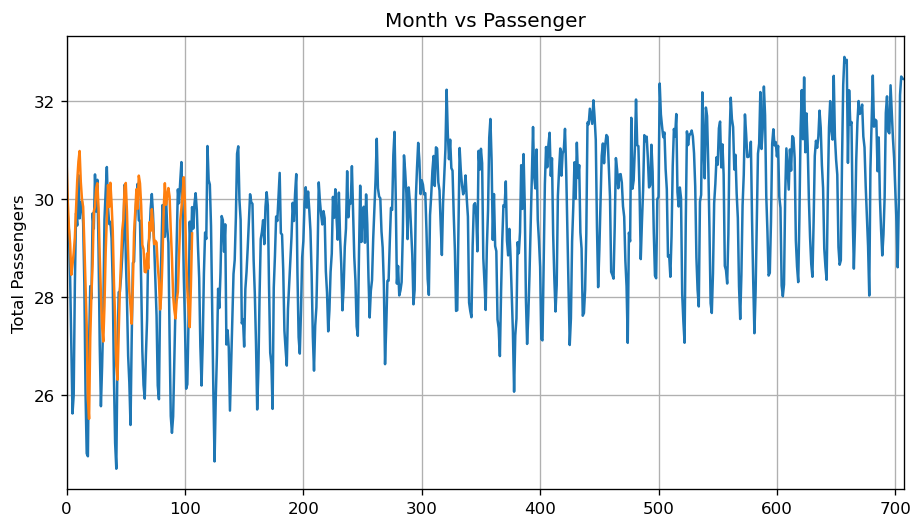

In [119]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df.Maxima.values)
plt.plot(actual_predictions)
plt.show()

In [310]:
###########LSTM USANDO KERA ###########
##Nota: rodar o a celula do pytorch com treinoNormalizado

tamanhoTreino = 600

scaler = MinMaxScaler(feature_range=(-1, 1))
dadosNormalizados = scaler.fit_transform(df.Maxima.iloc[:].values.reshape(-1, 1))

treino = dadosNormalizados[:tamanhoTreino]
teste = dadosNormalizados[tamanhoTreino:]

In [311]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [],[]
    
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back,0])
    
    return np.array(dataX), np.array(dataY)

In [312]:
look_back = 1
trainX, trainY = create_dataset(treino, look_back)
testX, testY = create_dataset(teste, look_back)

In [313]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [314]:
model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
598/598 - 2s - loss: 0.0863 - 2s/epoch - 4ms/step
Epoch 2/100
598/598 - 1s - loss: 0.0486 - 903ms/epoch - 2ms/step
Epoch 3/100
598/598 - 1s - loss: 0.0461 - 902ms/epoch - 2ms/step
Epoch 4/100
598/598 - 1s - loss: 0.0460 - 904ms/epoch - 2ms/step
Epoch 5/100
598/598 - 1s - loss: 0.0461 - 903ms/epoch - 2ms/step
Epoch 6/100
598/598 - 1s - loss: 0.0457 - 879ms/epoch - 1ms/step
Epoch 7/100
598/598 - 1s - loss: 0.0458 - 913ms/epoch - 2ms/step
Epoch 8/100
598/598 - 1s - loss: 0.0459 - 896ms/epoch - 1ms/step
Epoch 9/100
598/598 - 1s - loss: 0.0457 - 893ms/epoch - 1ms/step
Epoch 10/100
598/598 - 1s - loss: 0.0458 - 900ms/epoch - 2ms/step
Epoch 11/100
598/598 - 1s - loss: 0.0456 - 887ms/epoch - 1ms/step
Epoch 12/100
598/598 - 1s - loss: 0.0457 - 908ms/epoch - 2ms/step
Epoch 13/100
598/598 - 1s - loss: 0.0458 - 917ms/epoch - 2ms/step
Epoch 14/100
598/598 - 1s - loss: 0.0457 - 915ms/epoch - 2ms/step
Epoch 15/100
598/598 - 1s - loss: 0.0456 - 904ms/epoch - 2ms/step
Epoch 16/100
598/598 -

In [315]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [316]:
trainScore = m.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
testScore = m.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
testScore

0.9337672892893738

In [317]:
x = range(601,707)

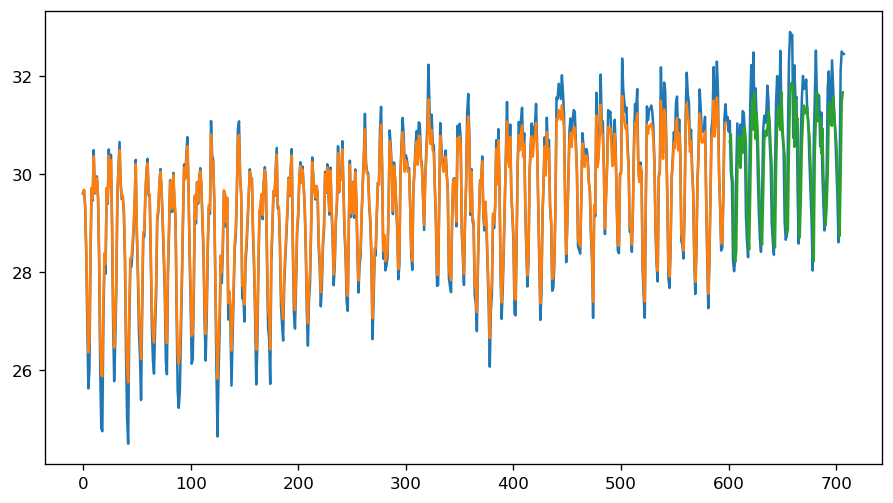

In [318]:
plt.plot(df.Maxima.values)
plt.plot(trainPredict)
plt.plot(x,testPredict)

In [319]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 4)                 96        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [22]:
for ano in range(1961, 1999):
    dadosPlot.Data = dadosPlot.Data.transform(lambda x: str(ano) if str(x).startswith(str(ano)) else x)

NameError: name 'dadosPlot' is not defined

<AxesSubplot:xlabel='Data', ylabel='Precipitacao'>

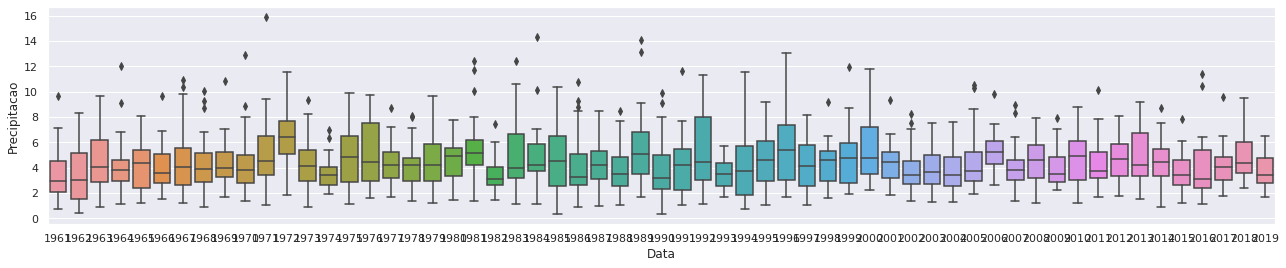

In [47]:
sns.set(rc={"figure.figsize":(22, 4)}) #width=8, height=4
sns.boxplot(x="Data", y="Precipitacao", data=dadosPlot)

In [215]:
######FUNCOES PARA CRIAR PASTAS######

In [33]:
def defineMes(mes):
    if(mes == 1):
        return "janeiro"
    elif(mes == 2):
        return "fevereiro"
    elif(mes == 3):
        return "marco"
    elif(mes == 4):
        return "abril"
    elif(mes == 5):
        return "maio"
    elif(mes == 6):
        return "junho"
    elif(mes == 7):
        return "julho"
    elif(mes == 8):
        return "agosto"
    elif(mes == 9):
        return "setembro"
    elif(mes == 10):
        return "outubro"
    elif(mes == 11):
        return "novembro"
    elif(mes == 12):
        return "dezembro"

def criaDiretorio(diretorioPai, nome):   
    path = os.path.join(diretorioPai, nome)
    os.makedirs(path)

In [ ]:
######CRIA GRAFICOS MENSAIS PARA CADA ESTADOS######

In [327]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']
for sigla in estados:
    planilhaEstado = planilha[planilha.Nome.str.contains('- ' + sigla)]
    planilhaEstado['Data'] = pd.to_datetime(planilhaEstado['Data'], format='%d/%m/%Y')
    
    dfmaxima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfminima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfprecipitacao = pd.DataFrame({'Ano': [],
                                   1: [], 
                                   2: [], 
                                   3: [], 
                                   4: [], 
                                   5: [], 
                                   6: [], 
                                   7: [], 
                                   8: [], 
                                   9: [], 
                                   10: [], 
                                   11: [], 
                                   12: []})


    for ano in range(1961, 2020, 1):
        dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(ano)]
        dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
        dftranspose = dfano.transpose()
        dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
        dfmaxima.Ano.mask(dfmaxima.index == ano - 1961, str(ano), inplace=True)
        dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
        dfminima.Ano.mask(dfminima.index == ano - 1961, str(ano), inplace=True)
        dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
        dfprecipitacao.Ano.mask(dfprecipitacao.index == ano - 1961, str(ano), inplace=True)
        
    dfmaxima.dropna(thresh=2, inplace = True)
    dfminima.dropna(thresh=2, inplace = True)
    dfprecipitacao.dropna(thresh=2, inplace = True)
    
    
    criaDiretorio("/home/fnadona/graficos", sigla)
    pasta = os.path.join("/home/fnadona/graficos", sigla)
    
    for i in range(1,13,1):
        dfmaxima.update(dfmaxima[i].fillna(dfmaxima[i].mean()))
        
        y = dfmaxima.iloc[:,i].values.reshape(-1, 1)  #dependent variable vector
        X = np.array(range(int(dfmaxima.iloc[0,0]), int(dfmaxima.iloc[0,0]) + len(dfmaxima))).reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        score = regressor.score(X_test, y_test)
        
        while(score < 0.0):
            y = dfmaxima.iloc[:,i].values.reshape(-1, 1)  #dependent variable vector
            X = np.array(range(int(dfmaxima.iloc[0,0]), int(dfmaxima.iloc[0,0]) + len(dfmaxima))).reshape(-1, 1)
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
            regressor = LinearRegression()
            regressor.fit(X_train, y_train)
            score = regressor.score(X_test, y_test)
        
        mes = defineMes(i)
        criaDiretorio(pasta, mes)
        caminhoPasta = os.path.join(pasta, mes)
        figura = os.path.join(caminhoPasta, mes + ".pdf")
    
        fig = plt.figure(i)
        plt.scatter(X_train, y_train, color='red') # plotting the observation line
        plt.title('Temperatura no mes de ' + mes)
        plt.xlabel('Anos', fontsize=15)
        plt.ylabel('Temperatura (Celsius)', fontsize=15)
        plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
        plt.legend()
        fig.savefig(figura, format='pdf')
        fig.clear(True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
######CRIA TABELAS DE MEDIAS ANUAIS PARA CADA ESTADO######

In [5]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']

dfBrasilMax = pd.DataFrame()
dfBrasilMin = pd.DataFrame()
dfBrasilPrecipitacao = pd.DataFrame()

dfBrasilMax['Ano'] = dfmaxima['Ano']
dfBrasilMin['Ano'] = dfminima['Ano']
dfBrasilPrecipitacao['Ano'] = dfprecipitacao['Ano']

for sigla in estados:
    planilhaEstado = planilha[planilha.Nome.str.contains('- ' + sigla)]
    planilhaEstado['Data'] = pd.to_datetime(planilhaEstado['Data'], format='%d/%m/%Y')
    
    dfmaxima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfminima = pd.DataFrame({'Ano': [],
                             1: [], 
                             2: [], 
                             3: [], 
                             4: [], 
                             5: [], 
                             6: [], 
                             7: [], 
                             8: [], 
                             9: [], 
                             10: [], 
                             11: [], 
                             12: []})

    dfprecipitacao = pd.DataFrame({'Ano': [],
                                   1: [], 
                                   2: [], 
                                   3: [], 
                                   4: [], 
                                   5: [], 
                                   6: [], 
                                   7: [], 
                                   8: [], 
                                   9: [], 
                                   10: [], 
                                   11: [], 
                                   12: []})

    for ano in range(1961, 2020, 1):
        dfmanausano = planilhaEstado[planilhaEstado.Data.dt.to_period('Y') == str(ano)]
        dfano = dfmanausano.groupby([dfmanausano['Data'].dt.month]).mean()
        dftranspose = dfano.transpose()
        dfmaxima = dfmaxima.append(dftranspose.loc['TempMaxima'], ignore_index=True)
        dfmaxima.Ano.mask(dfmaxima.index == ano - 1961, str(ano), inplace=True)
        dfminima = dfminima.append(dftranspose.loc['TempMinima'], ignore_index=True)
        dfminima.Ano.mask(dfminima.index == ano - 1961, str(ano), inplace=True)
        dfprecipitacao = dfprecipitacao.append(dftranspose.loc['Precipitacao'], ignore_index=True)
        dfprecipitacao.Ano.mask(dfprecipitacao.index == ano - 1961, str(ano), inplace=True)
        
    dfmaxima.dropna(thresh=2, inplace = True)
    dfminima.dropna(thresh=2, inplace = True)
    dfprecipitacao.dropna(thresh=2, inplace = True)
    
    for i in range(1,13,1):
        dfmaxima.update(dfmaxima[i].fillna(dfmaxima[i].mean()))
        dfminima.update(dfminima[i].fillna(dfminima[i].mean()))
        dfprecipitacao.update(dfprecipitacao[i].fillna(dfprecipitacao[i].mean()))
        
    dfBrasilMax[sigla] = dfmaxima.drop(columns=['Ano'], axis=1).mean(axis=1)
    dfBrasilMin[sigla] = dfminima.drop(columns=['Ano'], axis=1).mean(axis=1)
    dfBrasilPrecipitacao[sigla] = dfprecipitacao.drop(columns=['Ano'], axis=1).mean(axis=1)

In [ ]:
######CRIA GRAFICOS DA MEDIAS ANUAIS PARA CADA ESTADO######

In [76]:
estados = ['AP', 'AM', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']
criaDiretorio("/home/fnadona/graficos", "chuva")
pasta = os.path.join("/home/fnadona/graficos", "chuva")
k=1
for sigla in estados:
    dfGraficos = dfBrasilPrecipitacao[['Ano', sigla]].dropna()
    dfGraficos['Ano'] = dfGraficos.Ano.transform(lambda x: float(x))
    dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
        
    y = dfGraficos.iloc[:,1].values.reshape(-1, 1)  #dependent variable vector
    X = dfGraficos.iloc[:,0].values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
        
#     while(score < 0.0):
#         y = dfmaxima.iloc[:,i].values.reshape(-1, 1)  #dependent variable vector
#         X = np.array(range(int(dfmaxima.iloc[0,0]), int(dfmaxima.iloc[0,0]) + len(dfmaxima))).reshape(-1, 1)
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
#         regressor = LinearRegression()
#         regressor.fit(X_train, y_train)
#         score = regressor.score(X_test, y_test)
        
#     mes = defineMes(i)
    figura = os.path.join(pasta, sigla + ".pdf")
    
    fig = plt.figure(k)
    plt.scatter(X_train, y_train, color='red') # plotting the observation line
    plt.title('Temperatura no estado ' + sigla)
    plt.xlabel('Anos', fontsize=15)
    plt.ylabel('Temperatura (Celsius)', fontsize=15)
    plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
    plt.legend()
    fig.savefig(figura, format='pdf')
    fig.clear(True)
    k = k+1

# dfGraficos =dfBrasilMax[['Ano', 'RR']].dropna()
# dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
# dfGraficos

<ipython-input-76-e6c6dd99975f>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(k)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
######CRIA GRAFICO DE MEDIA ANUAL PARA O BRASIL######

In [91]:
criaDiretorio("/home/fnadona/graficos", "chuvaBrasil")
pasta = os.path.join("/home/fnadona/graficos", "chuvaBrasil")

dfGraficos = pd.DataFrame()

dfGraficos['Media'] = dfBrasilPrecipitacao.drop(columns=['Ano'], axis=1).mean(axis=1)
dfGraficos['Ano'] = dfBrasilPrecipitacao.Ano.transform(lambda x: float(x))
dfGraficos = dfGraficos.set_index(pd.Index(range(0, len(dfGraficos), 1)))
        
y = dfGraficos.iloc[:,0].values.reshape(-1, 1)  #dependent variable vector
X = dfGraficos.iloc[:,1].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
        
while(score < 0.1):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
        
figura = os.path.join(pasta, "Brasil.pdf")
    
fig = plt.figure()
plt.scatter(X_train, y_train, color='red') # plotting the observation line
plt.title('Temperatura no Brasil')
plt.xlabel('Anos', fontsize=15)
plt.ylabel('Temperatura (Celsius)', fontsize=15)
plt.plot(X_train, regressor.predict(X_train), color='blue', label = "Score = " + str(np.round(score,3)))# plotting the regression line
plt.legend()
fig.savefig(figura, format='pdf')
fig.clear(True)

<Figure size 432x288 with 0 Axes>

In [10]:
dados.head()

Estacao        Data  Precipitacao  TempMaxima  TempMinima  Temp Comp Media
0    82024  01/01/1961           NaN        32.3         NaN            26.56
1    82024  01/01/1961           NaN         NaN        22.9              NaN
2    82024  01/01/1961           NaN         NaN         NaN              NaN
3    82024  02/01/1961           NaN        33.2         NaN            28.06
4    82024  02/01/1961          16.0         NaN        23.7              NaN

In [2]:
exemploEstacao = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/weather_stations_codes.csv'
                      , sep=";")
exemploDados = pd.read_csv('./BrazilWeatherConventionalStations(1961-2019)/conventional_weather_stations_inmet_brazil_1961_2019.csv'
                      , sep=";")

In [11]:
exemploEstacao.dtypes

Nome                   object
Código                  int64
Latitude              float64
Longitude             float64
Altitude              float64
Status da Operação     object
Ínicio da Operação     object
dtype: object

In [21]:

        
# csvFile = dffinal.to_csv('tabelaTeste.csv', date_format='%d/%m/%Y', index=True)

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dffinal = dffinal.append(dfagrupado, ignore_index=False)
/tmp/ipykernel_10069/673637833.py:13: FutureWarning: The frame.append method is 

In [22]:
dffinal

Precipitacao  TempMaxima  TempMinima  Temp Comp Media          Nome  \
Codigo                                                                        
82294            0.0        29.1        22.6            24.84   ACARAU - CE   
82294            0.6        28.6        23.2            24.88   ACARAU - CE   
82294            2.6        29.8        21.8            25.64   ACARAU - CE   
82294           22.1        29.4        19.6            24.76   ACARAU - CE   
82294           12.5        29.0        22.2            24.88   ACARAU - CE   
...              ...         ...         ...              ...           ...   
82376            0.0        34.9        23.4            28.00  ZE DOCA - MA   
82376            0.0        35.5        24.0            29.14  ZE DOCA - MA   
82376            0.5        31.3        24.6            27.28  ZE DOCA - MA   
82376            8.5        30.9        23.5            25.98  ZE DOCA - MA   
82376           44.2        28.1        21.4            24.80  ZE DOCA - MA   

             Data  
Codigo             
82294  1976-03-04  
82294  1976-03-05  
82294  1976-03-06  
82294  1976-03-07  
82294  1976-03-08  
...           ...  
82376  2019-12-27  
82376  2019-12-28  
82376  2019-12-29  
82376  2019-12-30  
82376  2019-12-31  

[3697349 rows x 6 columns]

In [ ]:
######CRIA TABELA PRINCIPAL######

In [21]:
estados = ['AP', 'AM', 'RO', 'RR', 'AC', 'PA', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA', 'MT', 'GO', 'MS', 'SP', 'MG', 'RJ', 'ES', 'PR', 'SC', 'RS', 'DF']
dffinal = pd.DataFrame()

for station in estados:
    estacao = estacaoplanilha[estacaoplanilha.Nome.str.contains('- ' + station)]
    for codigo in estacao['Código']:
        dfdados = dados[dados.Estacao == codigo]
        dfjoin = dfdados.set_index("Estacao").join(estacao.set_index("Código"))
        dfjoin.Data = pd.to_datetime(dfjoin.Data, format='%d/%m/%Y')
        dfagrupado = dfjoin.groupby('Data').max()
        dfagrupado.Precipitacao = dfagrupado.Precipitacao.transform(lambda x: 0.0 if m.isnan(x) else x)
        dfagrupado = dfagrupado.dropna()
        dfagrupado['Data'] = dfagrupado.index
        dfagrupado['Codigo'] = dfagrupado.Nome.transform(lambda x: estacao.loc[estacao.Nome == x, 'Código'].values[0])
        dfagrupado = dfagrupado.set_index('Codigo')
        dffinal = dffinal.append(dfagrupado, ignore_index=False)
        
csvFile = dffinal.to_csv('tabelaTeste.csv', date_format='%d/%m/%Y', index=True)

Precipitacao  TempMaxima  TempMinima  Temp Comp Media           Nome  \
Codigo                                                                         
82098            0.0        32.4        20.4            27.40    MACAPA - AP   
82098            0.0        32.4        20.4            27.20    MACAPA - AP   
82098            0.0        32.4        20.4            26.72    MACAPA - AP   
82098            0.0        32.4        20.4            26.92    MACAPA - AP   
82098            0.0        33.2        22.2            27.68    MACAPA - AP   
...              ...         ...         ...              ...            ...   
83373            0.0        29.0        12.8            20.88  RONCADOR - DF   
83373            0.0        29.8        18.4            22.10  RONCADOR - DF   
83373            0.0        27.4        15.4            20.64  RONCADOR - DF   
83373            0.0        23.4        14.6            18.84  RONCADOR - DF   
83373            0.0        30.2        10.6            20.98  RONCADOR - DF   

             Data  
Codigo             
82098  1967-12-01  
82098  1967-12-02  
82098  1967-12-03  
82098  1967-12-04  
82098  1967-12-05  
...           ...  
83373  2017-09-14  
83373  2017-09-18  
83373  2017-09-21  
83373  2017-09-22  
83373  2017-09-26  

[3697349 rows x 6 columns]

In [23]:
dffinal.isnull().sum()

Precipitacao       0
TempMaxima         0
TempMinima         0
Temp Comp Media    0
Nome               0
Data               0
dtype: int64

In [ ]:
######CRIA GRAFICOS DE BARRAS PARA CADA MES DE UM ESTACAO######

<ipython-input-30-f4e1e3e94f5b>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(12,1,mes)


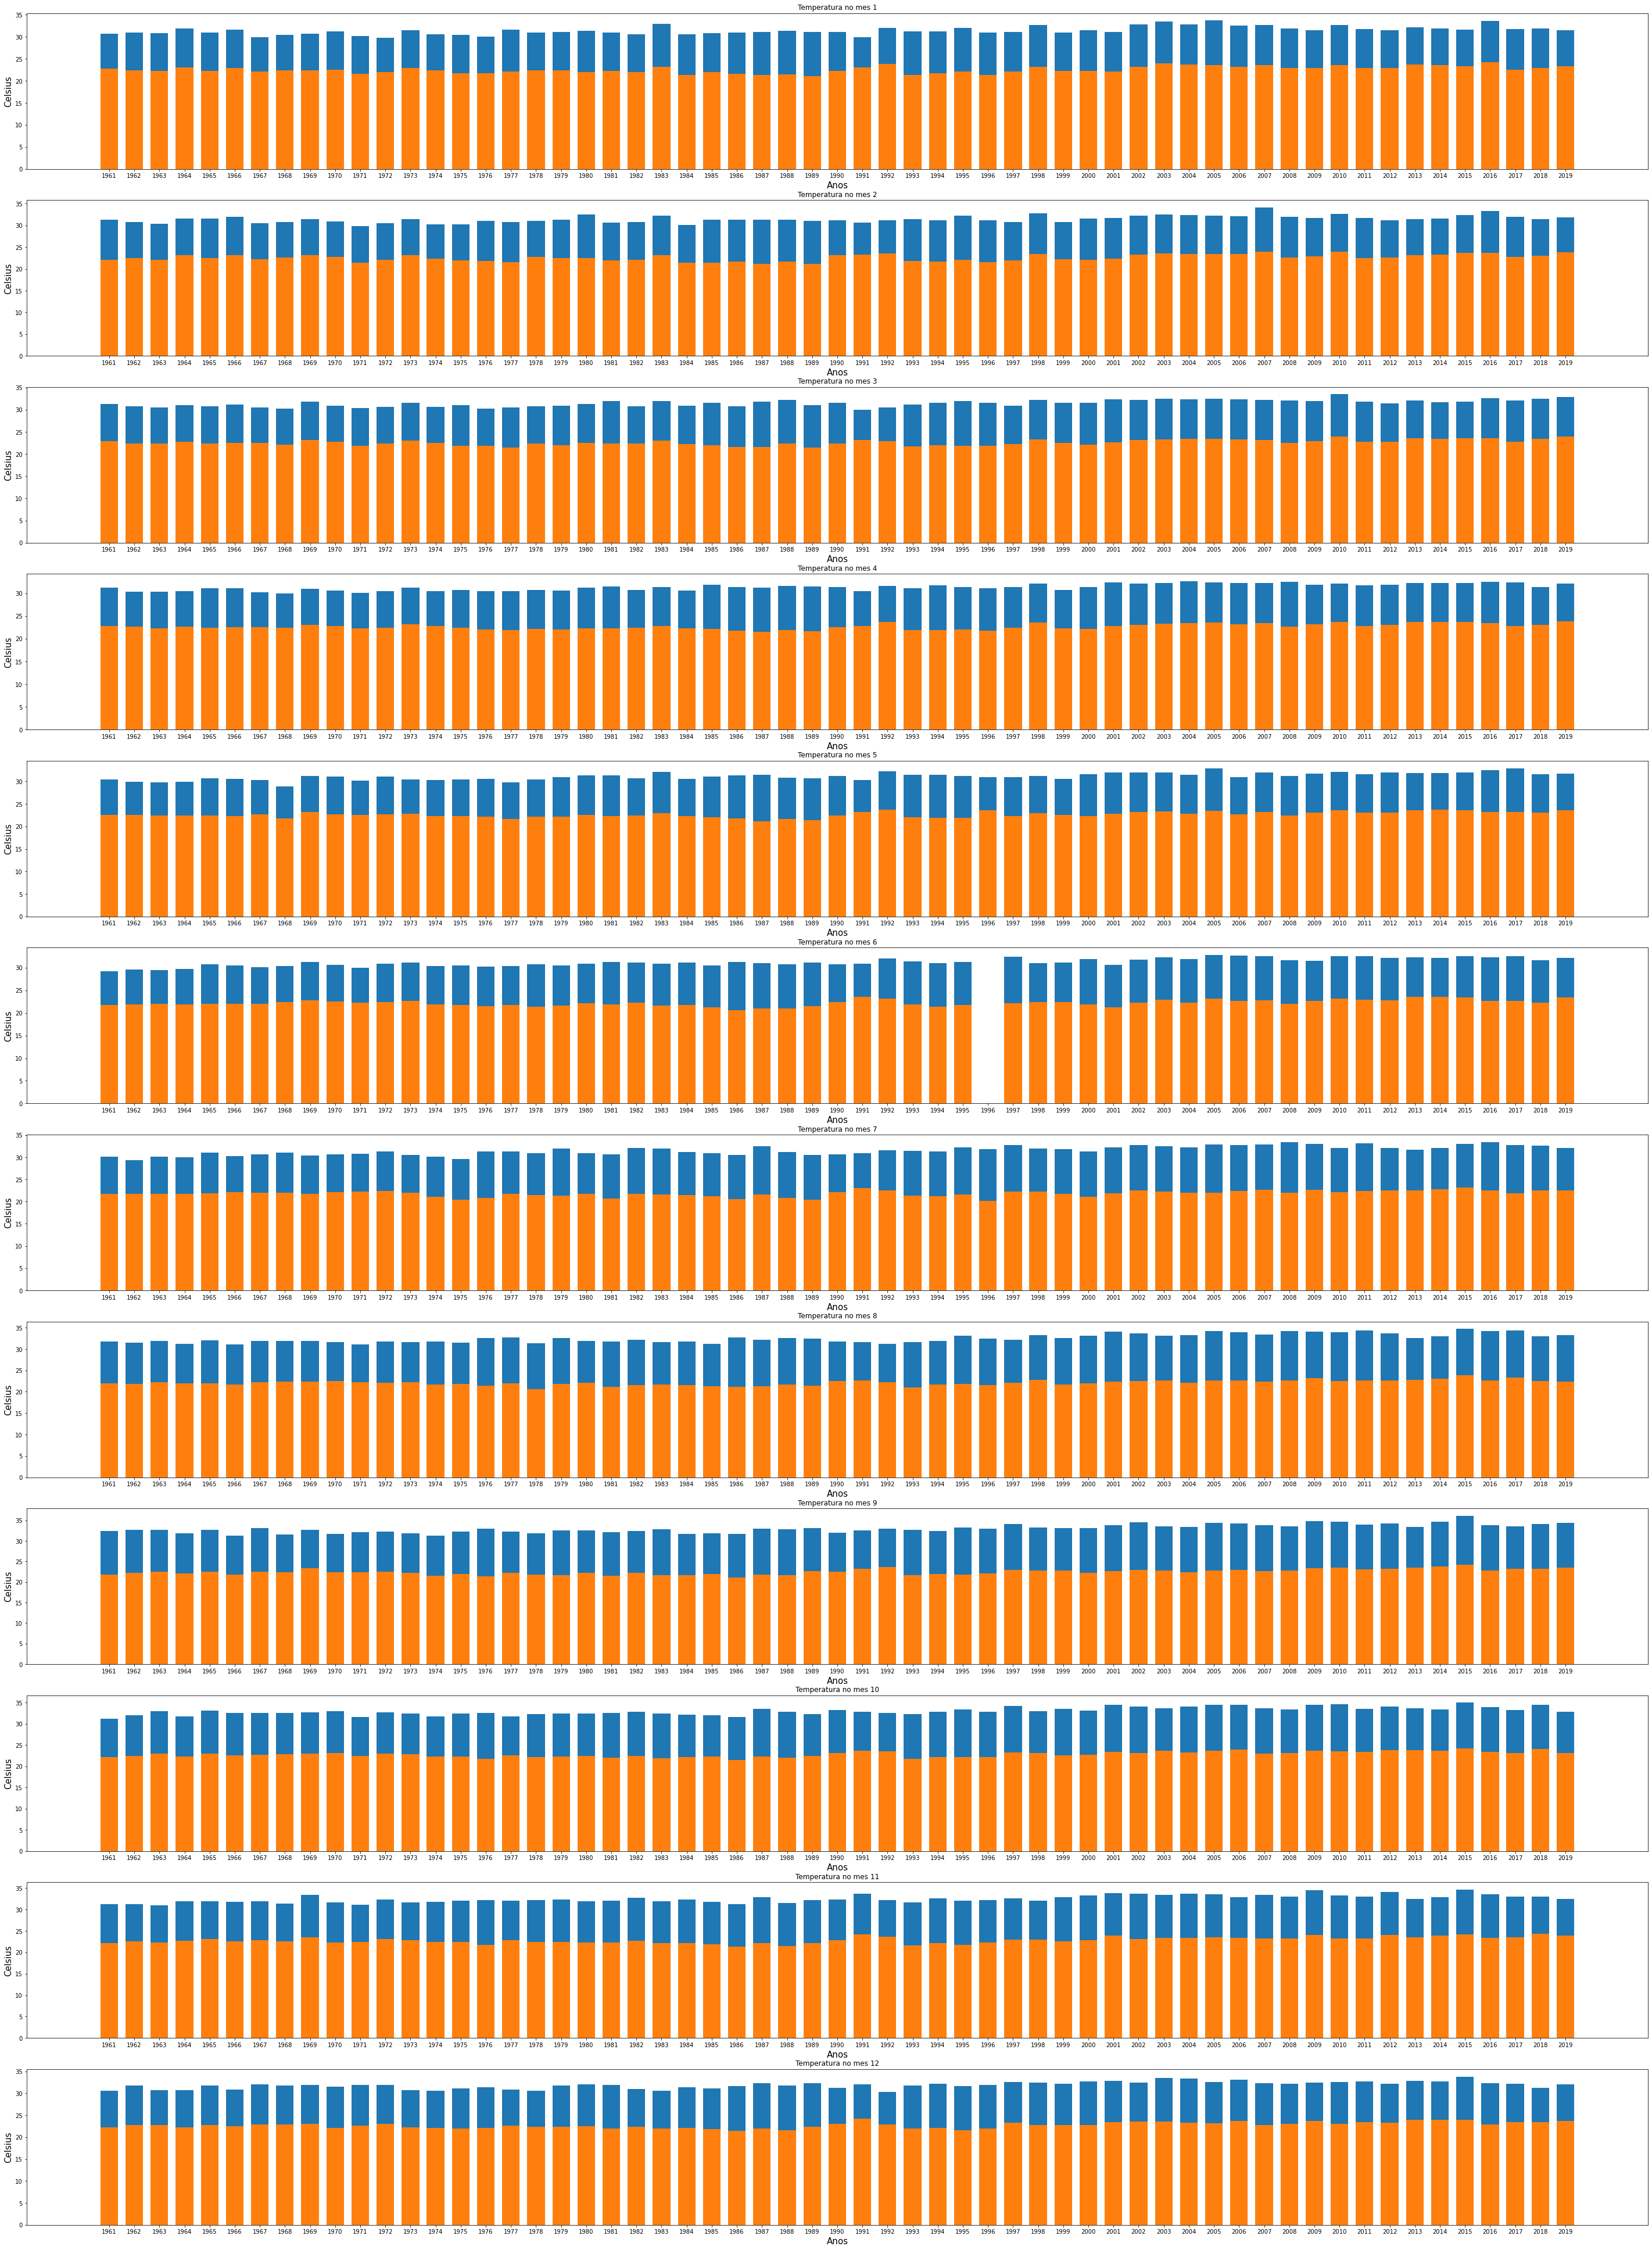

In [30]:
plt.figure(figsize=(50,70))

#FAZER O PLOT DA TEMPERATURA MAXIMA EM CADA MES POR ANO
# dfteste = dfmaxima.transpose()
# for ano in range(1961, 1979, 1):
#     plt.subplot(6,3,ano-1960)
#     plt.bar(dfteste.index, dfteste['1961'], width=0.7)
#     plt.title('Temperatura nos meses de ' + str(ano))
#     plt.xlabel('Meses', fontsize=15)
#     plt.ylabel('Celsius', fontsize=15)

for mes in range(1,13,1):
    plt.subplot(12,1,mes)
    plt.bar(dfmaxima.index, dfmaxima[mes], width=0.7)
    plt.title('Temperatura no mes ' + str(mes))
    plt.xlabel('Anos', fontsize=15)
    plt.ylabel('Celsius', fontsize=15)

    plt.subplot(12,1,mes)
    plt.bar(dfminima.index, dfminima[mes], width=0.7)
    
plt.show()

In [ ]:
######CRIA GRAFICOS DE DISPERSAO PARA CADA MES DE UM ESTACAO######

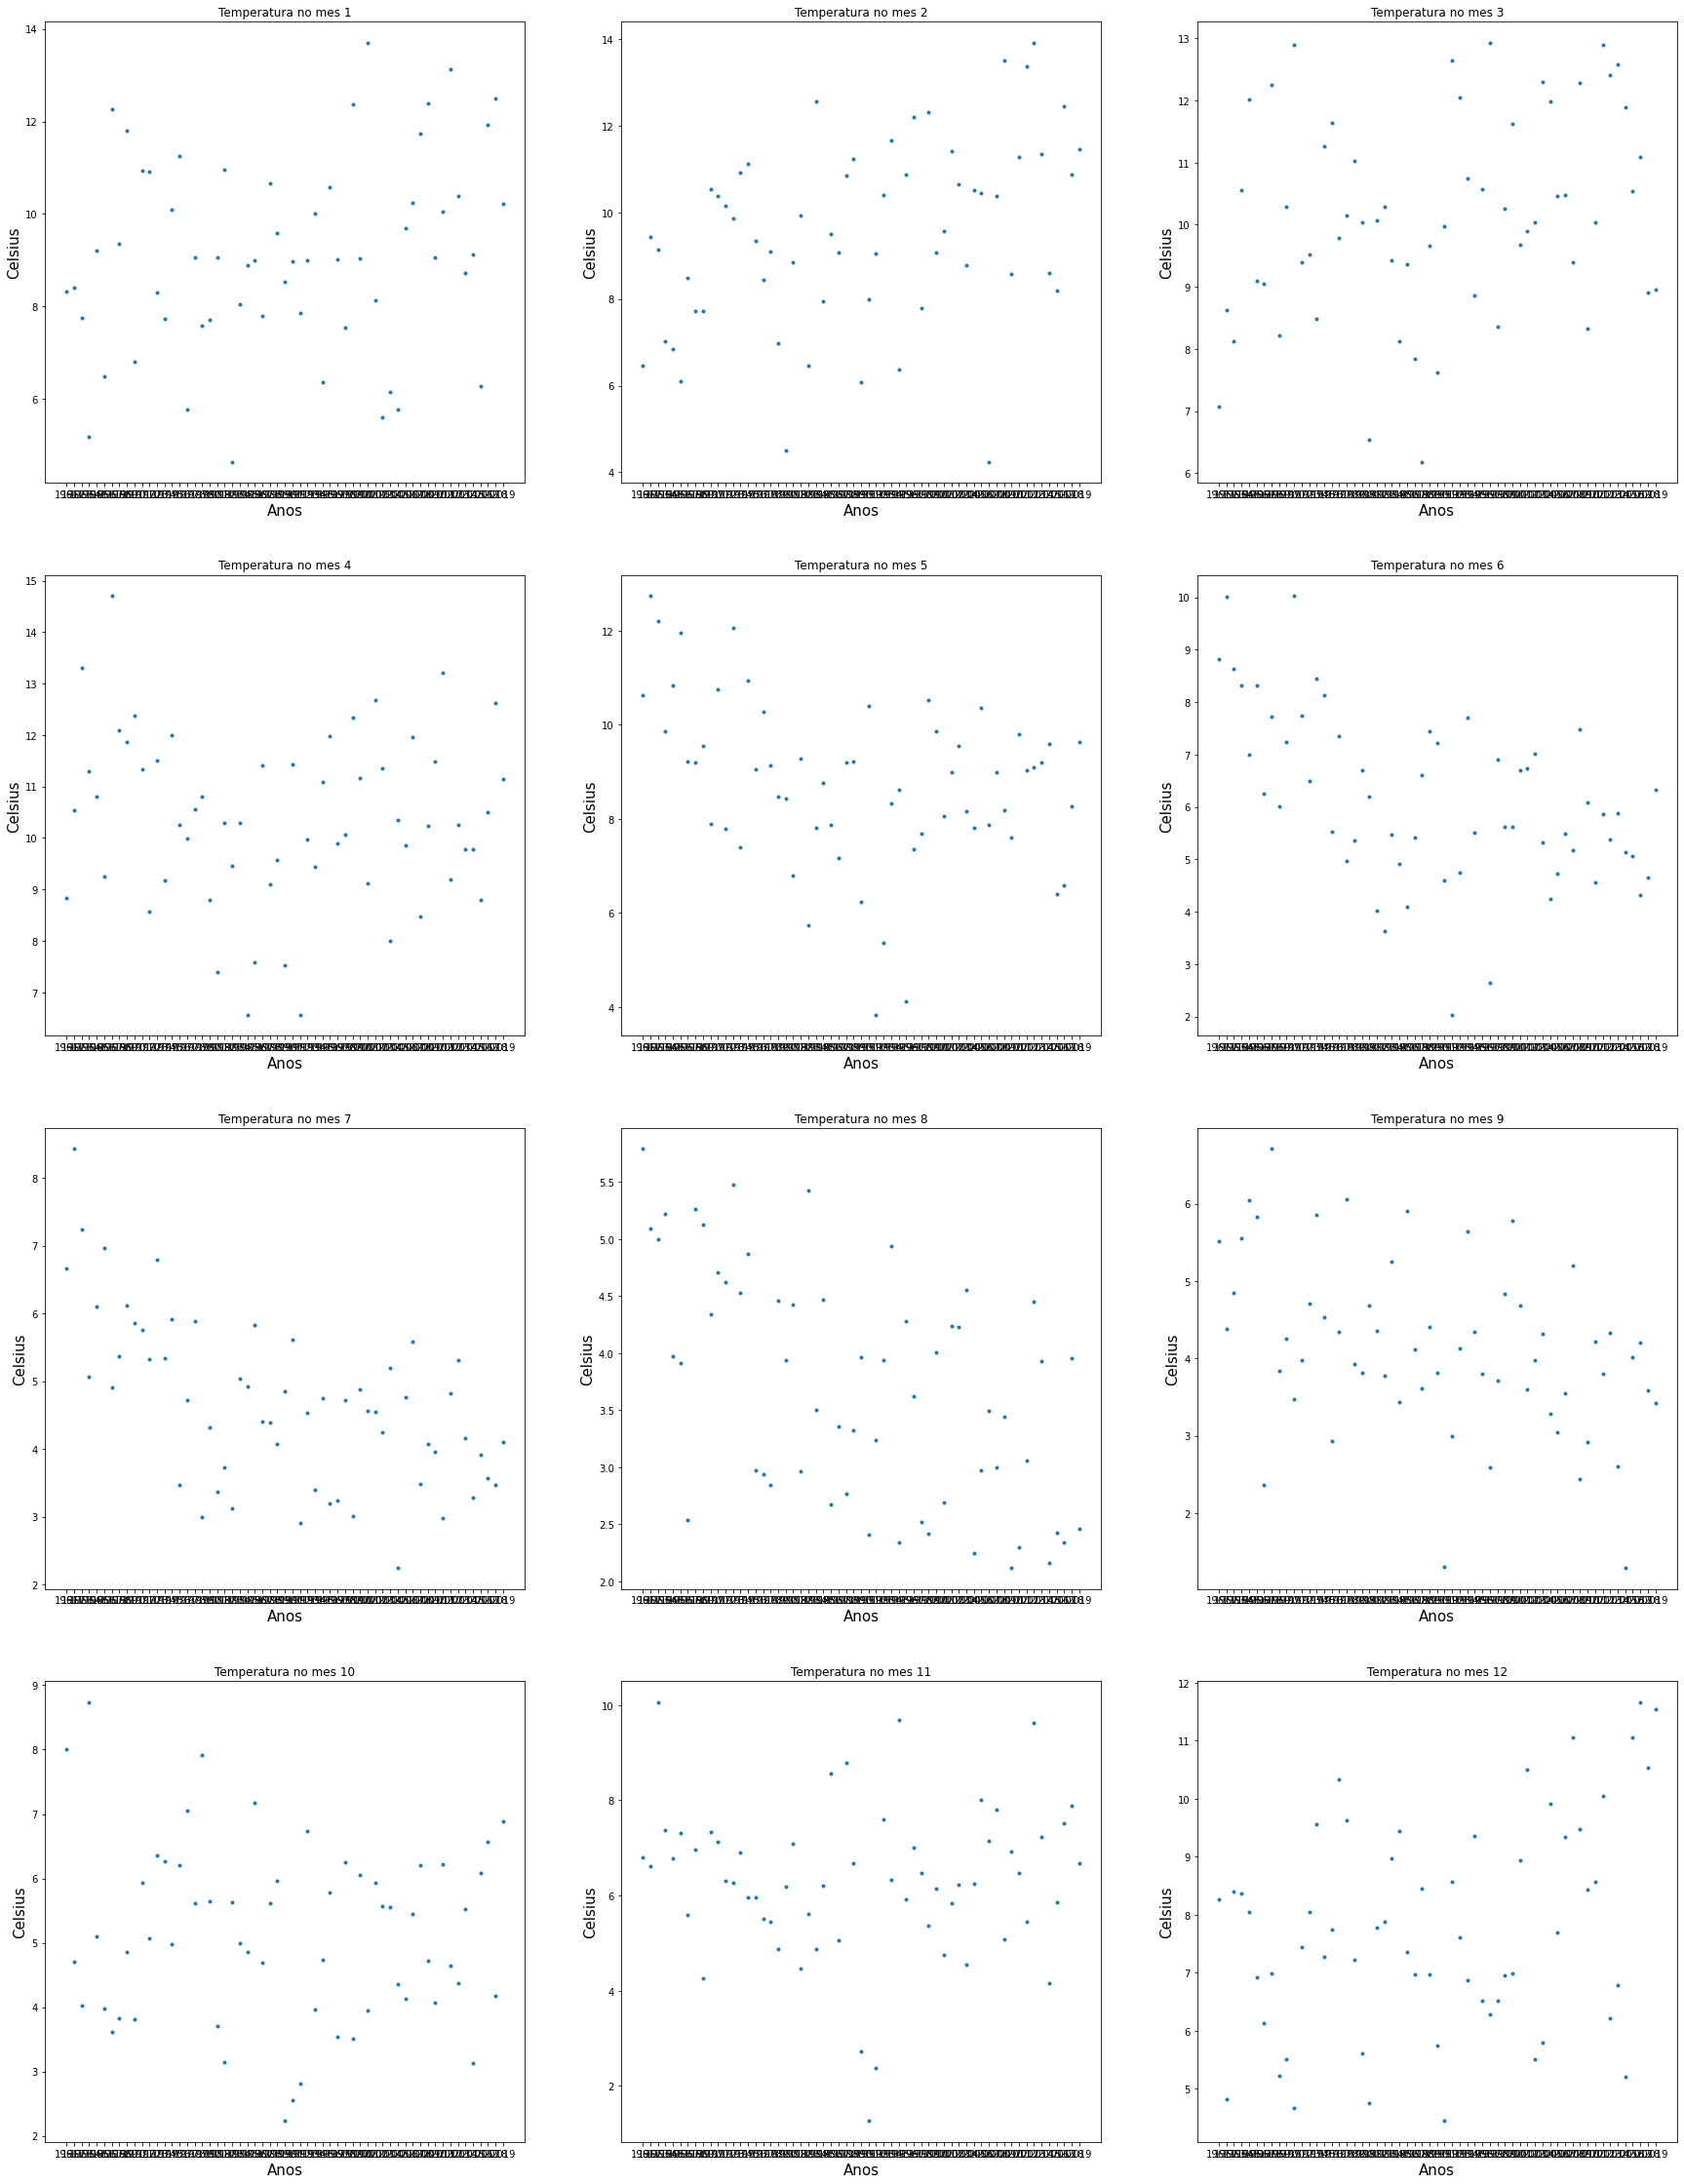

In [31]:
plt.figure(figsize=(30,40))

for mes in range(1,13,1):
    plt.subplot(4,3,mes)
    plt.plot(dfprecipitacao.index, dfprecipitacao[mes], '.')
    plt.title('Temperatura no mes ' + str(mes))
    plt.xlabel('Anos', fontsize=15)
    plt.ylabel('Celsius', fontsize=15)

#     plt.subplot(12,1,mes)
#     plt.bar(dfminima.index, dfminima[mes], width=0.7)
    
plt.show()